**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/FSR.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01   546   565  546    546        0                7.765   
1 1999-01-04   546   547  536    536   539932                7.882   
2 1999-01-05   536   548  536    546  1681254                7.765   
3 1999-01-06   553   621  553    620  8254865                6.824   
4 1999-01-07   620   663  612    621  8852081                6.824   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0               2.0000        12.878300      0           0   
1               2.0000        12.687135      0           0   
2               2.0000        12.878300      0           0   
3               1.7647        14.654162      0           0   
4               1.7647        14.654162      0           0   

   Total Return Index (TRI)  
0                 68.082755  
1                 66.835818  
2                 68.082755  
3                 77.310088  
4                 77.434782

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.018258 -0.048163  0.028359  0.024980  0.006601 -0.013072   
2000-05-12 -0.083169 -0.003252  0.009820  0.038179  0.034801  0.016421   
2000-05-15 -0.103772  0.040557  0.024136  0.033956  0.062315  0.058937   
2000-05-16 -0.119168  0.063695  0.004758  0.028894  0.038715  0.067073   
2000-05-17 -0.111512  0.041431 -0.025642 -0.020884  0.003252  0.013072   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.095956 -0.074422 -0.046180  -0.054685  ...     -0.088983   
2000-05-12 -0.076837 -0.050699 -0.052256  -0.045334  ...     -0.033956   
2000-05-15 -0.045022 -0.020280 -0.053951  -0.029717  ...     -0.003252   
2000-05-16 -0.008464  0.007711 -0.047881  -0.012733  ...      0.040557   
2000-05-17  0.018854  0.018951 -0.039668  -0.002885  ...      0.058937   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.070348     -0.050805          -0.050805         -0.030475   
2000-05-12     0.004955     -0.012800          -0.012800          0.027757   
2000-05-15     0.013158      0.027007           0.035091          0.054764   
2000-05-16     0.051209      0.057708           0.061014          0.084466   
2000-05-17     0.077611      0.045536           0.058937          0.098495   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11           -0.038343           -0.060625          -0.040296   
2000-05-12            0.008084           -0.024136           0.016421   
2000-05-15            0.054764            0.020884           0.040557   
2000-05-16            0.079394            0.045315           0.068767   
2000-05-17            0.062315            0.038053           0.077611   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.060625         -0.068654  
2000-05-12           -0.024136          0.006601  
2000-05-15            0.012800          0.016421  
2000-05-16            0.042009          0.064009  
2000-05-17            0.024652          0.098495  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.0028456915935860545
  dropout = 0.05978181747288375
  units = 256
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 20
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0018213401511749565
RMSE = 0.042677161939085835
MAE = 0.03210001465773057
R-Squared = -0.10410501451964693

Results on Validation set: 
MSE = 0.000881515904327399
RMSE = 0.029690333516607707
MAE = 0.024202663256551637
R-Squared = -0.43585337558924864

Results on Testing set: 
MSE = 0.0009883019051578276
RMSE = 0.03143726936548128
MAE = 0.024622710927774474
R-Squared = 0.07278139987014809



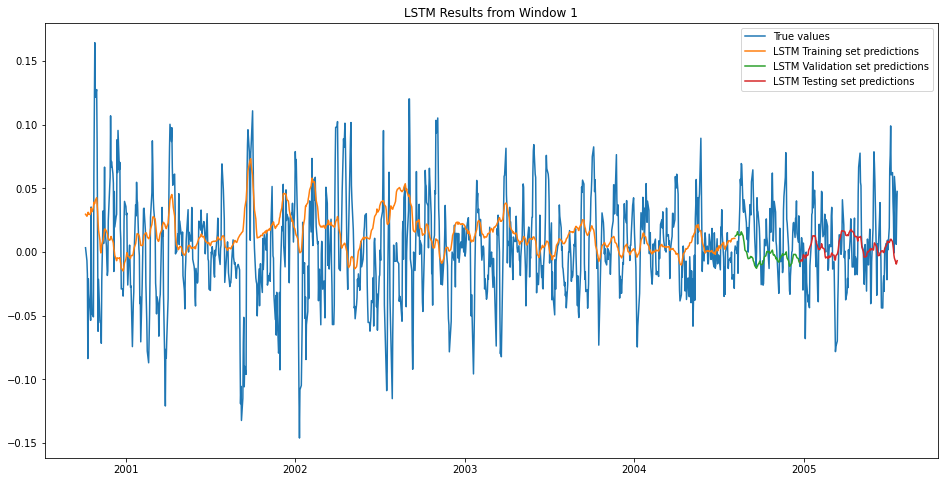

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0013403228074973998
RMSE = 0.03661041938434194
MAE = 0.0274568687344148
R-Squared = 0.022922789107395092

Results on Validation set: 
MSE = 0.0012389313033466926
RMSE = 0.035198455979583716
MAE = 0.026120430788444823
R-Squared = -0.03358587358381837

Results on Testing set: 
MSE = 0.001568281192732162
RMSE = 0.03960153018170083
MAE = 0.03184843289595827
R-Squared = -0.030048452839265938



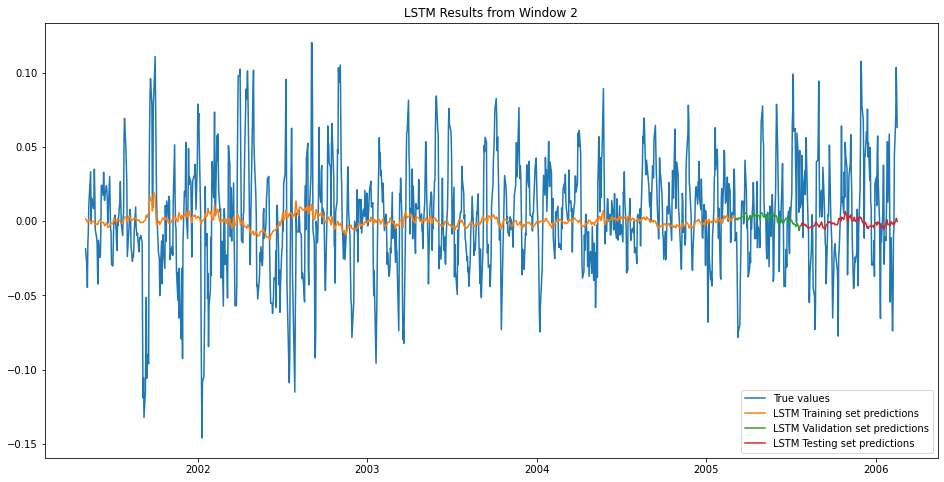

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 7.95174501437651e-05
RMSE = 0.008917255751842329
MAE = 0.0065367585808445835
R-Squared = 0.938485434491491

Results on Validation set: 
MSE = 0.0013415661678229098
RMSE = 0.03662739641065018
MAE = 0.029594032370179817
R-Squared = 0.20477902909207413

Results on Testing set: 
MSE = 0.0030359125732297106
RMSE = 0.05509911590243269
MAE = 0.04323411969009792
R-Squared = -0.2908366432223326



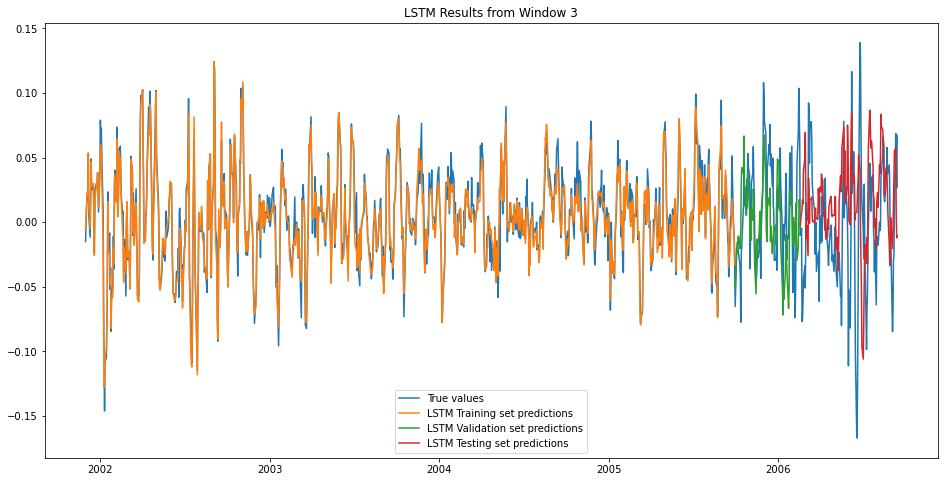

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0011866502681941414
RMSE = 0.03444779046897117
MAE = 0.025756610260150956
R-Squared = 0.017214315717830164

Results on Validation set: 
MSE = 0.0024511662808235656
RMSE = 0.049509254496746015
MAE = 0.037260769806616884
R-Squared = 0.1253821583136875

Results on Testing set: 
MSE = 0.0016394477197868877
RMSE = 0.04049009409456698
MAE = 0.03169493360961854
R-Squared = -0.10006013682199089



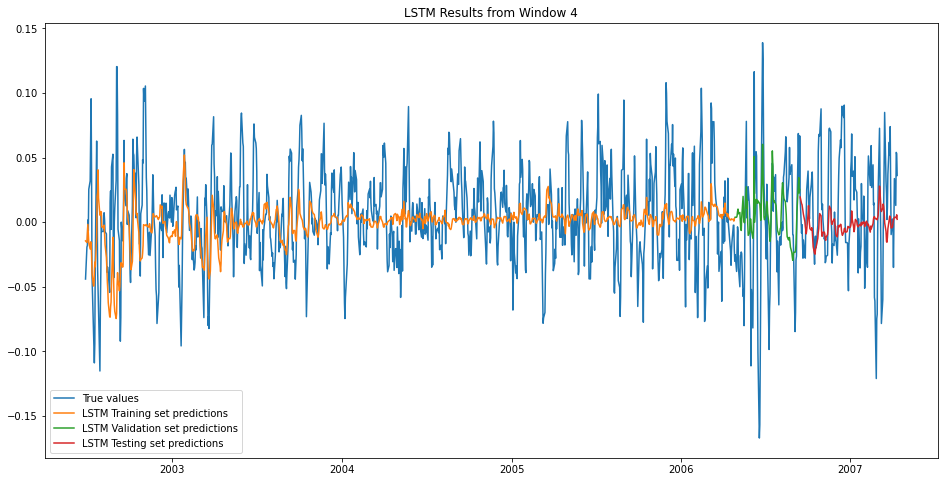

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0011307371738384093
RMSE = 0.03362643563981186
MAE = 0.02637171960492928
R-Squared = 0.09315966927933472

Results on Validation set: 
MSE = 0.0015633692286192756
RMSE = 0.03953946419236452
MAE = 0.030677576208454634
R-Squared = 0.07901563706099346

Results on Testing set: 
MSE = 0.001306473872721469
RMSE = 0.036145177724303264
MAE = 0.02912921085120703
R-Squared = 0.07584492271146481



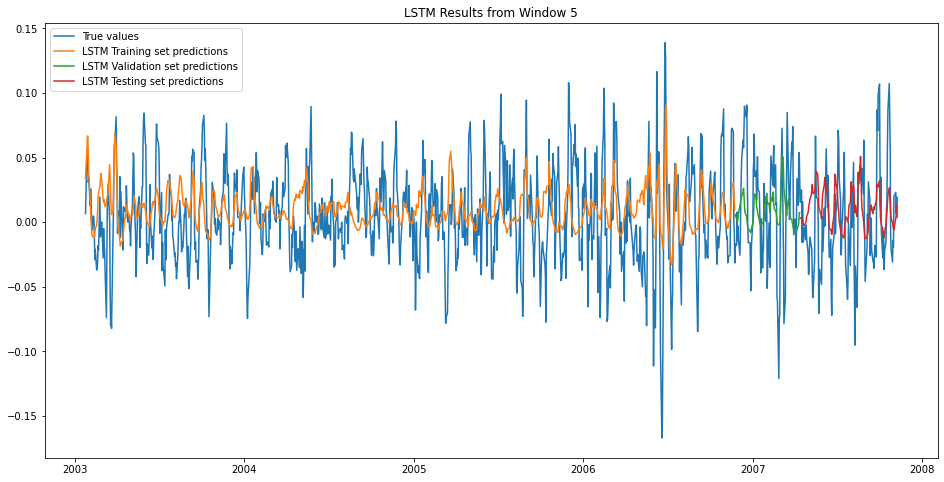

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0008197435611017154
RMSE = 0.028631164159036833
MAE = 0.021359239018754434
R-Squared = 0.3817716202878334

Results on Validation set: 
MSE = 0.0011770336360524757
RMSE = 0.03430792380853839
MAE = 0.027330247343286162
R-Squared = 0.23601728779148456

Results on Testing set: 
MSE = 0.006233631552633775
RMSE = 0.07895335048390141
MAE = 0.06843519174568181
R-Squared = -1.9235867552546275



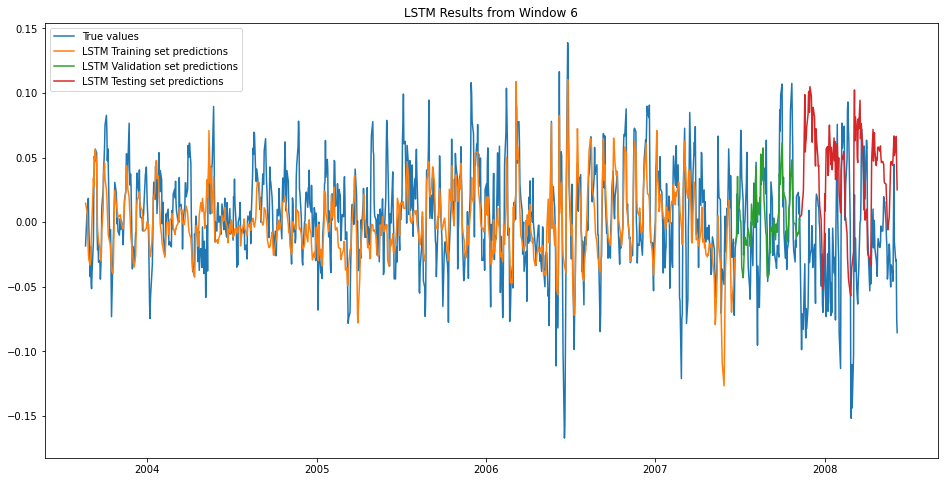

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0011611461175516443
RMSE = 0.03407559416285568
MAE = 0.02569874119063866
R-Squared = 0.21710030037185657

Results on Validation set: 
MSE = 0.00239646623177646
RMSE = 0.04895371519891478
MAE = 0.03736448556328751
R-Squared = 0.018192895432809664

Results on Testing set: 
MSE = 0.005143229755234113
RMSE = 0.0717163144286857
MAE = 0.055363733071899235
R-Squared = -0.04899770093454192



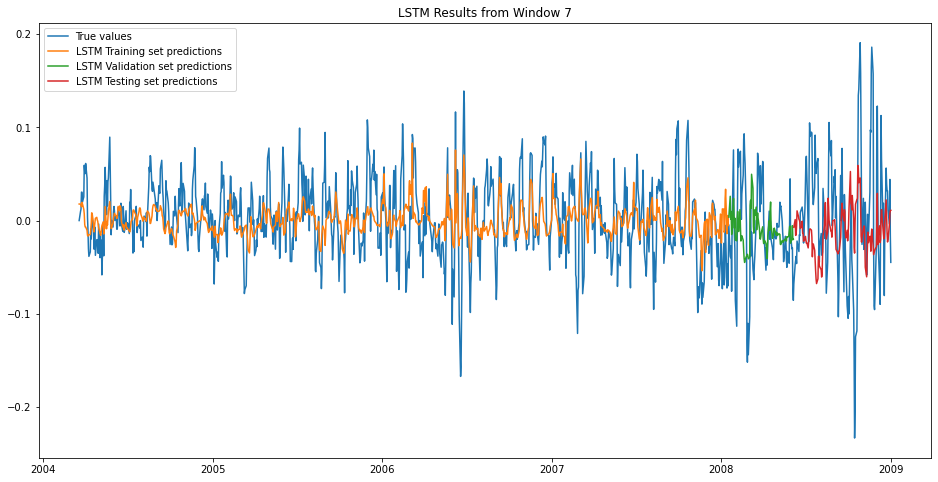

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0016676439439606812
RMSE = 0.04083679644586095
MAE = 0.03146310373116542
R-Squared = 0.039850001976346916

Results on Validation set: 
MSE = 0.006011645930343769
RMSE = 0.07753480463858646
MAE = 0.05930813762310987
R-Squared = 0.047759543814318794

Results on Testing set: 
MSE = 0.003768922970200457
RMSE = 0.061391554551098126
MAE = 0.04635198561275076
R-Squared = 0.020335883080390804



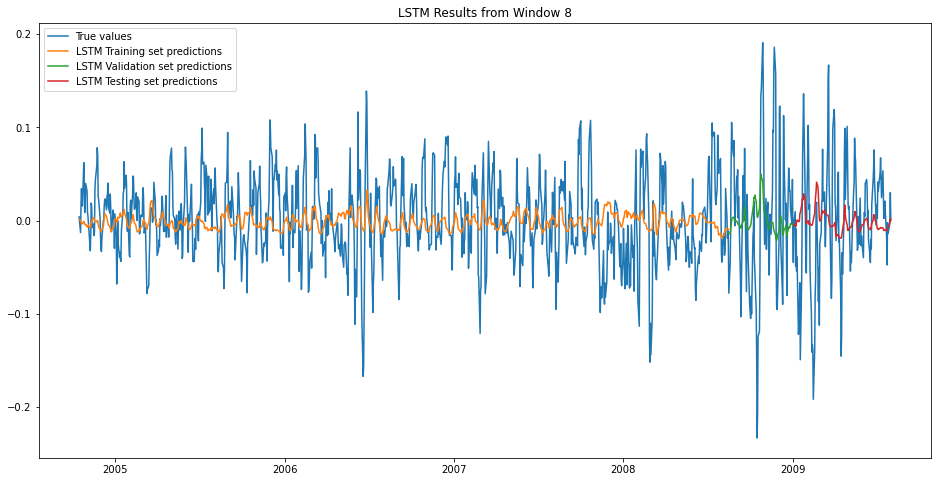

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0019240910259330879
RMSE = 0.043864461992974314
MAE = 0.0323536166603393
R-Squared = 0.24177253809610777

Results on Validation set: 
MSE = 0.002098439774293347
RMSE = 0.04580873032832657
MAE = 0.03432358379087571
R-Squared = 0.19120759283633737

Results on Testing set: 
MSE = 0.0007933943869901629
RMSE = 0.02816725735655076
MAE = 0.02263644632399689
R-Squared = 0.015052838308017624



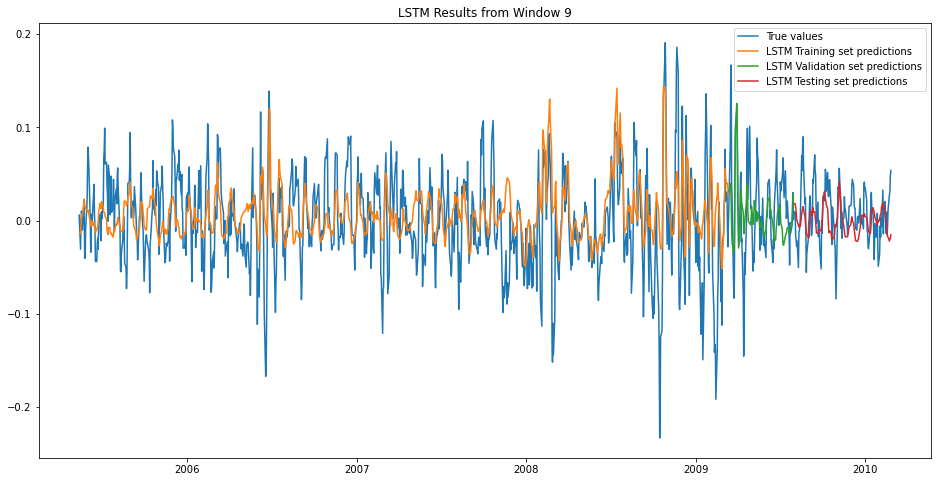

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.002564839917611064
RMSE = 0.05064424861335257
MAE = 0.03801736218681856
R-Squared = 0.03689441506604174

Results on Validation set: 
MSE = 0.0006094927572350409
RMSE = 0.02468790710520114
MAE = 0.019489067564663162
R-Squared = -0.001025265266038966

Results on Testing set: 
MSE = 0.0011416081098170228
RMSE = 0.033787691691162074
MAE = 0.027558242643017383
R-Squared = -0.0017791947938079478



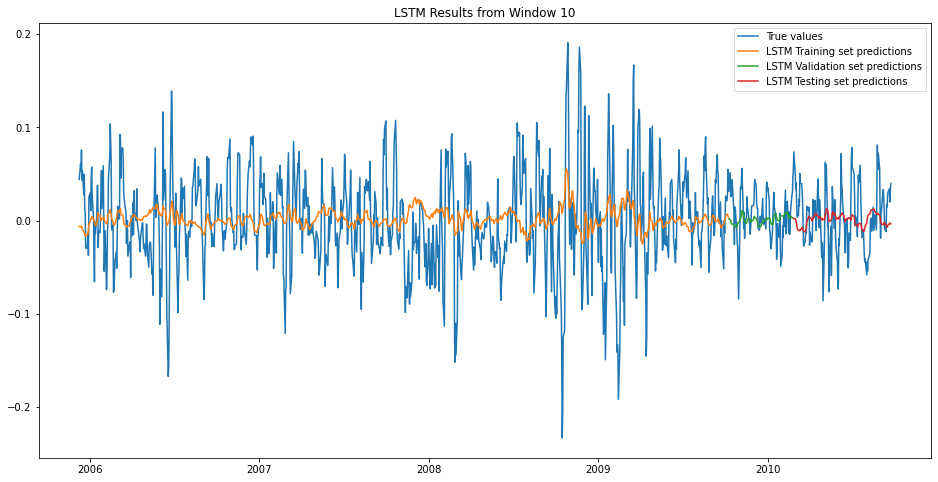

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0022095861215944974
RMSE = 0.04700623492255573
MAE = 0.03484332586767482
R-Squared = 0.08249763425986678

Results on Validation set: 
MSE = 0.0011943280706006717
RMSE = 0.0345590519343438
MAE = 0.028304384834934634
R-Squared = 0.06271308993558966

Results on Testing set: 
MSE = 0.001110440811130888
RMSE = 0.03332327731677795
MAE = 0.02799027846132289
R-Squared = -0.03131459985228924



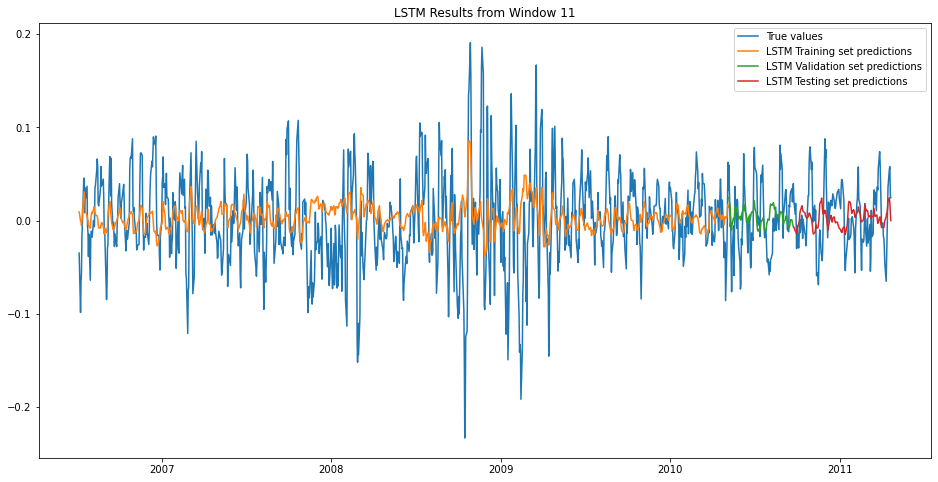

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0021442016798195827
RMSE = 0.04630552537030093
MAE = 0.03426082193955559
R-Squared = 0.10117187715906684

Results on Validation set: 
MSE = 0.0009033782941820109
RMSE = 0.03005625216459981
MAE = 0.025261056733549357
R-Squared = -0.018599961048130886

Results on Testing set: 
MSE = 0.0007848519717144995
RMSE = 0.028015209649661726
MAE = 0.0222595539686841
R-Squared = 0.04969242861683254



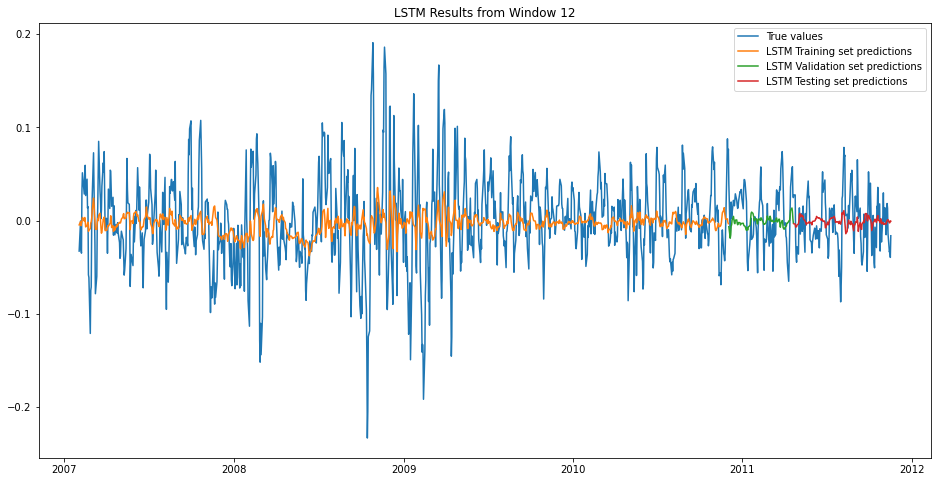

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0021309349615817484
RMSE = 0.04616205109807999
MAE = 0.034367969558953666
R-Squared = 0.06517877274752404

Results on Validation set: 
MSE = 0.0008438753650923363
RMSE = 0.02904953295824799
MAE = 0.02281974332925384
R-Squared = 0.11794736044950471

Results on Testing set: 
MSE = 0.0009613908532758301
RMSE = 0.031006303444232594
MAE = 0.02591413201937123
R-Squared = -0.6508647738892861



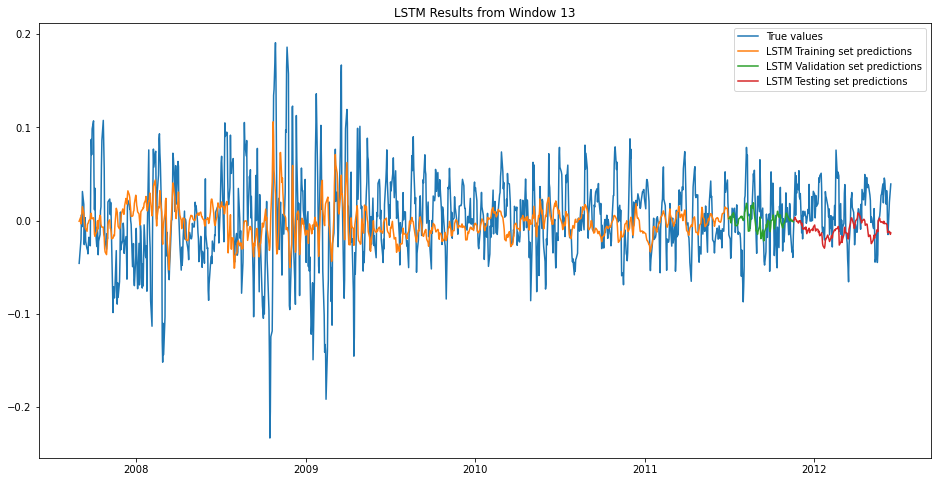

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0014085880947663132
RMSE = 0.03753116164957212
MAE = 0.02697909547555011
R-Squared = 0.29118280593466594

Results on Validation set: 
MSE = 0.000685825546656894
RMSE = 0.026188271165865338
MAE = 0.020794622033020863
R-Squared = -0.03270620477518715

Results on Testing set: 
MSE = 0.0008191262608674038
RMSE = 0.028620381913374317
MAE = 0.023121073963012783
R-Squared = 0.08440574448796379



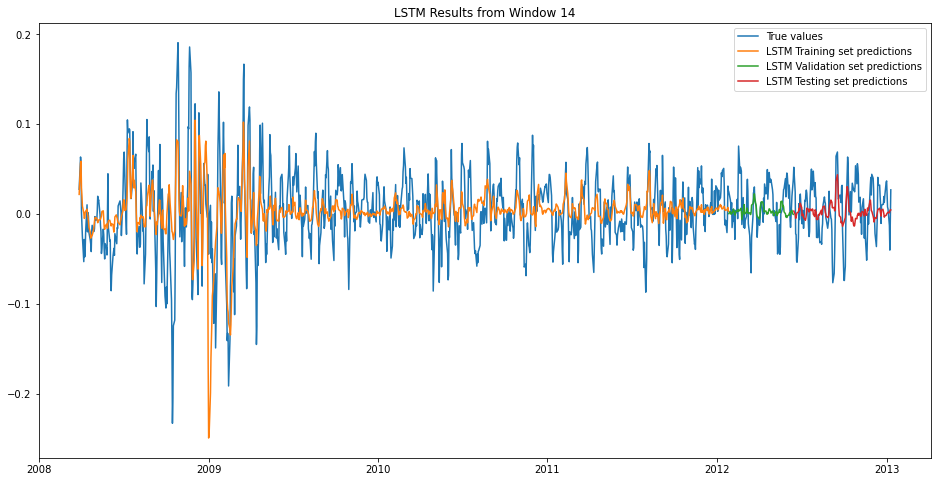

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0011858563325132993
RMSE = 0.03443626478747803
MAE = 0.025565622430419366
R-Squared = 0.2538693050651315

Results on Validation set: 
MSE = 0.0009591822979159235
RMSE = 0.030970668347904982
MAE = 0.024205885396308965
R-Squared = 0.05688723177440025

Results on Testing set: 
MSE = 0.0013320554101406723
RMSE = 0.03649733428814592
MAE = 0.02826017764669391
R-Squared = -0.35421277507343385



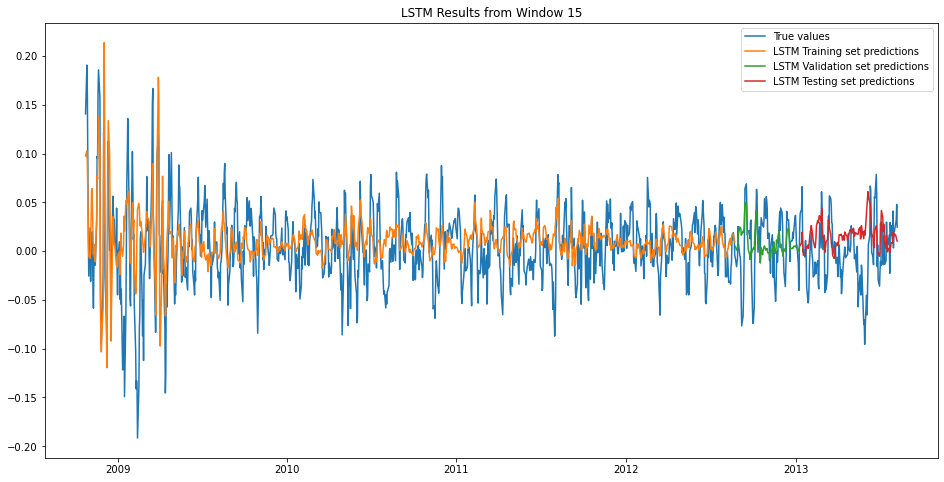

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0008330067289521085
RMSE = 0.02886185595127431
MAE = 0.023018462299584184
R-Squared = 0.08270453436321279

Results on Validation set: 
MSE = 0.0012187028341021009
RMSE = 0.03490992457886583
MAE = 0.02544510924135194
R-Squared = -0.2167279970545024

Results on Testing set: 
MSE = 0.001181596279188776
RMSE = 0.03437435496396661
MAE = 0.027167403208864495
R-Squared = -0.07601681529683635



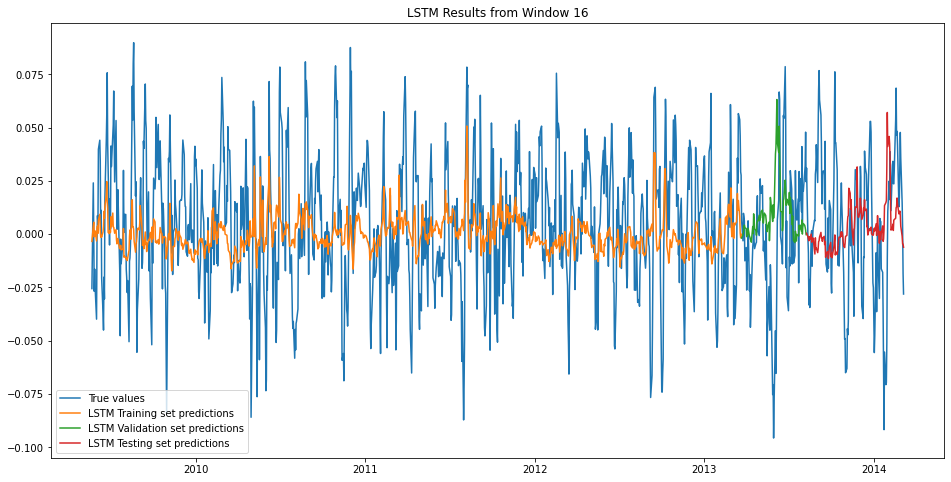

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0008394644200705413
RMSE = 0.028973512387533228
MAE = 0.02285526544978176
R-Squared = 0.08505120790760368

Results on Validation set: 
MSE = 0.0011167548270189476
RMSE = 0.03341788184518803
MAE = 0.02652400989962116
R-Squared = 0.03387272442277789

Results on Testing set: 
MSE = 0.0005922991111114701
RMSE = 0.024337196040453594
MAE = 0.01875849148352287
R-Squared = -0.1770467931467561



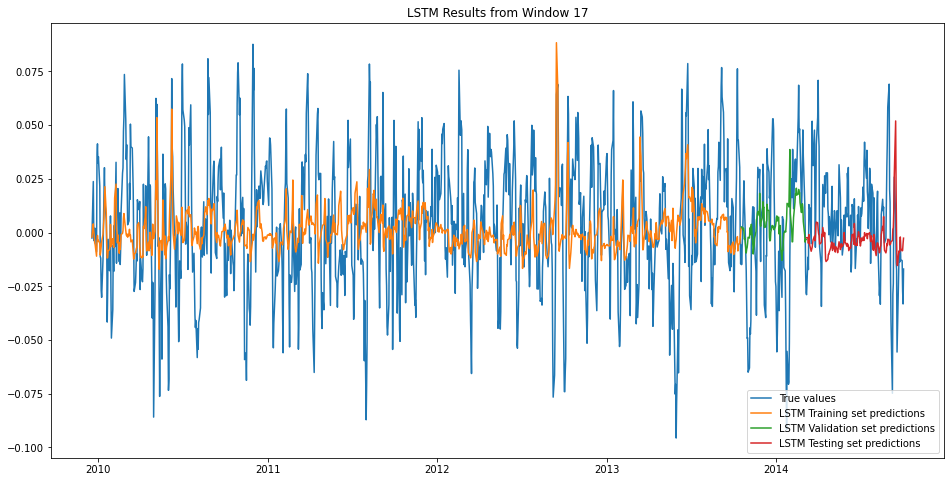

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0008832621764655591
RMSE = 0.029719727059069015
MAE = 0.023438249242806235
R-Squared = 0.036923003449984004

Results on Validation set: 
MSE = 0.0004593167597386772
RMSE = 0.02143167654988002
MAE = 0.01601904224448914
R-Squared = 0.07519299614155828

Results on Testing set: 
MSE = 0.0008383238648682956
RMSE = 0.028953822975011357
MAE = 0.022298397830579894
R-Squared = -0.08953586907388478



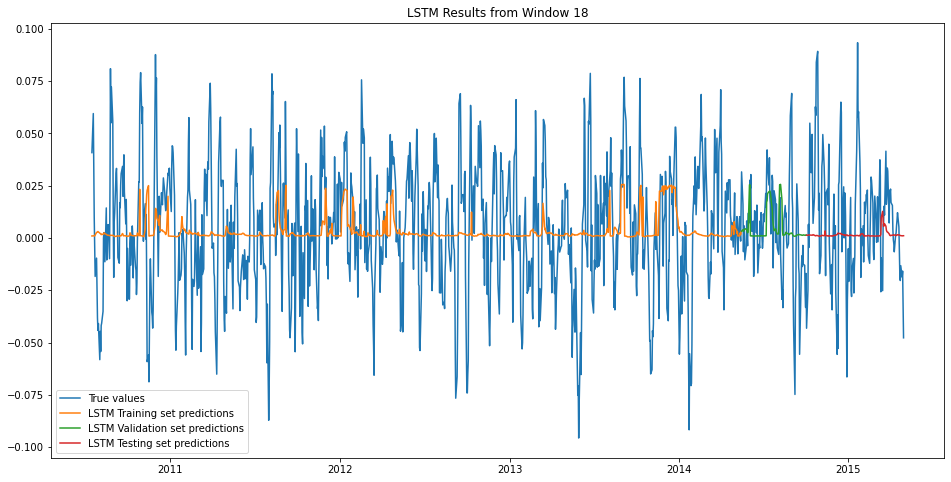

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0008275440915447374
RMSE = 0.028767066092056336
MAE = 0.022550213371772834
R-Squared = 0.038989264280504976

Results on Validation set: 
MSE = 0.0006007654518856391
RMSE = 0.024510517168873428
MAE = 0.018217768507415848
R-Squared = 0.02765652381233563

Results on Testing set: 
MSE = 0.0013031172920681797
RMSE = 0.03609871593378606
MAE = 0.029618352265066664
R-Squared = -0.13747099868470736



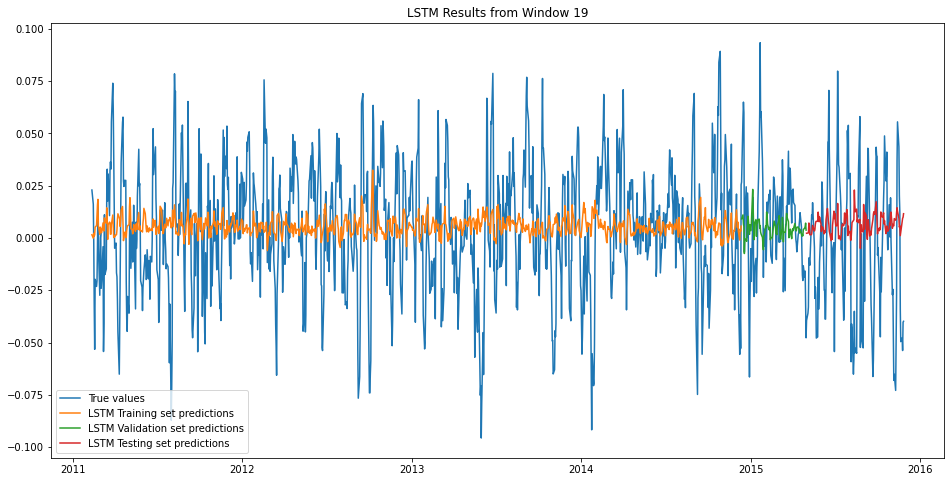

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0008240251647094362
RMSE = 0.028705838512564585
MAE = 0.022304706790006634
R-Squared = 0.00586882547066625

Results on Validation set: 
MSE = 0.001283598569015999
RMSE = 0.03582734387330435
MAE = 0.02938079208176752
R-Squared = -0.045792285522467946

Results on Testing set: 
MSE = 0.0033536995379543823
RMSE = 0.05791113483566336
MAE = 0.045934168855288685
R-Squared = 0.051054374582129025



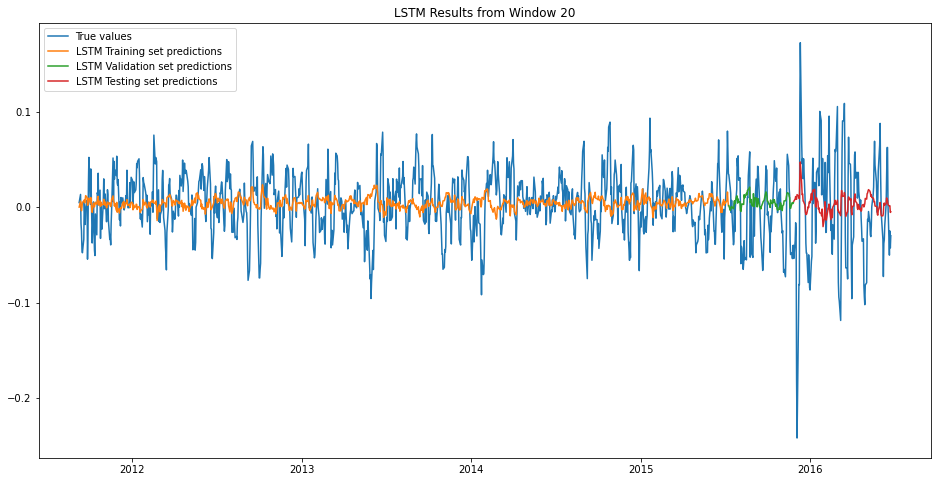

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001184158672139317
RMSE = 0.034411606648619544
MAE = 0.02574192258171646
R-Squared = -0.05176821125659736

Results on Validation set: 
MSE = 0.002350447591951423
RMSE = 0.04848141491284493
MAE = 0.04088843372596208
R-Squared = 0.13919628207852652

Results on Testing set: 
MSE = 0.0011921285060217748
RMSE = 0.03452721399160052
MAE = 0.026977850869657226
R-Squared = 0.037081927506433354



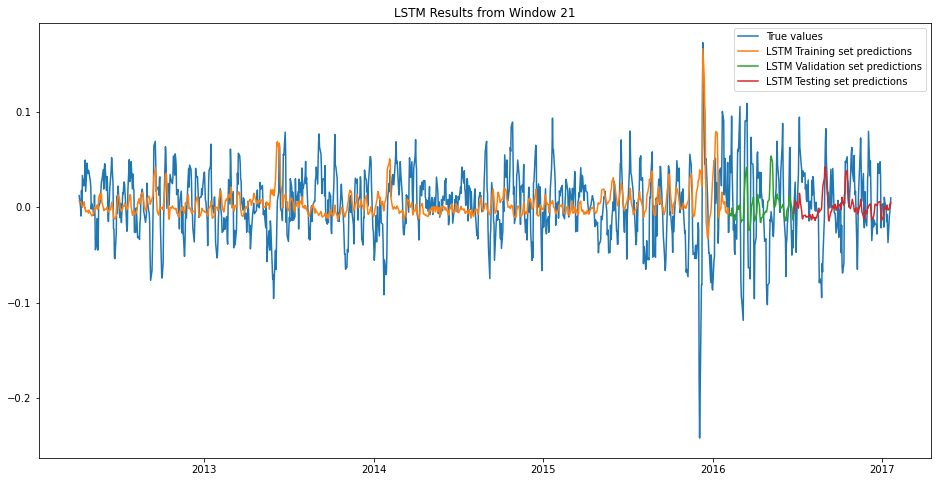

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0012526585345095577
RMSE = 0.035392916445378696
MAE = 0.026050313759269444
R-Squared = 0.07138757205621848

Results on Validation set: 
MSE = 0.0008150549121113085
RMSE = 0.02854916657472348
MAE = 0.023197753027379853
R-Squared = 0.14040006133550698

Results on Testing set: 
MSE = 0.0013793968554625662
RMSE = 0.03714023230221596
MAE = 0.027057348924337282
R-Squared = -0.104653817245703



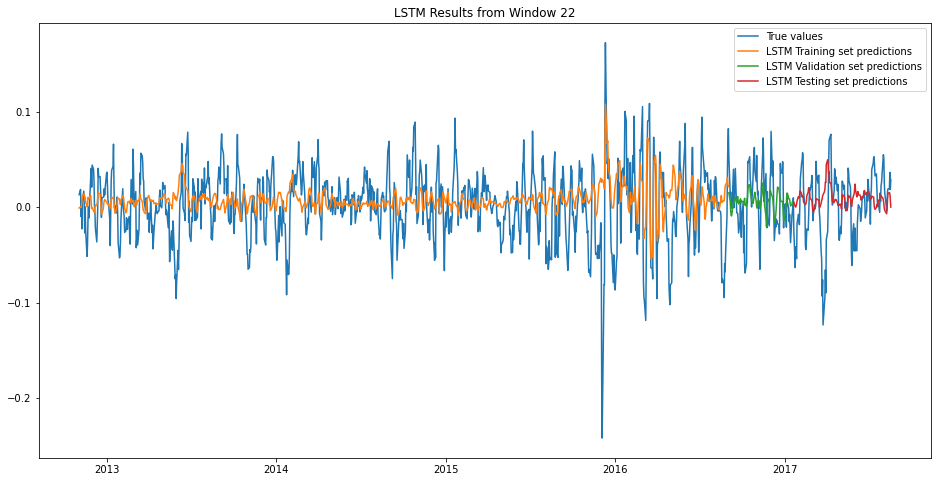

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.001340783394195359
RMSE = 0.036616709221274364
MAE = 0.027129787479647702
R-Squared = 0.06402434646527588

Results on Validation set: 
MSE = 0.0008257829967975983
RMSE = 0.02873644022487125
MAE = 0.02138822880130956
R-Squared = -0.1521622272492491

Results on Testing set: 
MSE = 0.0026895046661860864
RMSE = 0.051860434496695904
MAE = 0.039789106990478
R-Squared = -0.2072508339637218



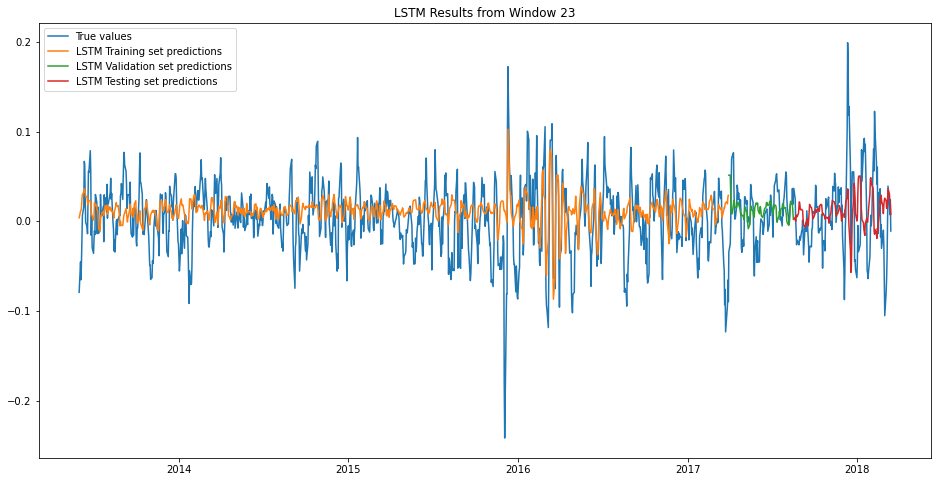

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0013450873082736909
RMSE = 0.03667543194392795
MAE = 0.02770026400868116
R-Squared = 0.030073946528586415

Results on Validation set: 
MSE = 0.0032858088063270246
RMSE = 0.05732197489904744
MAE = 0.04378310245800762
R-Squared = -0.11218453050022426

Results on Testing set: 
MSE = 0.0017770603510809423
RMSE = 0.042155193643025085
MAE = 0.03339366500031153
R-Squared = -0.02969746427317621



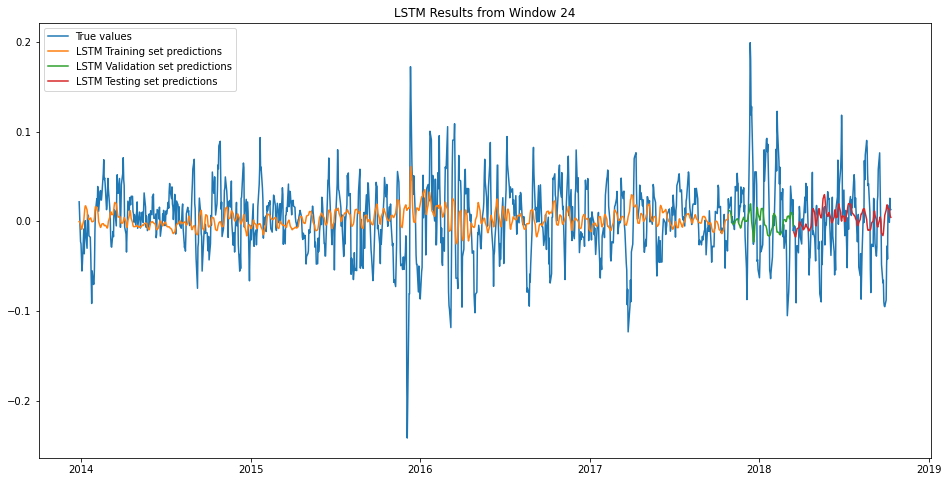

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0013958812366230379
RMSE = 0.037361494036280696
MAE = 0.02767130863597814
R-Squared = 0.1543248250736815

Results on Validation set: 
MSE = 0.0017184078026113237
RMSE = 0.041453682618210454
MAE = 0.032798802966526076
R-Squared = 0.1438609104117744

Results on Testing set: 
MSE = 0.000979378527031492
RMSE = 0.03129502399793763
MAE = 0.024423962409583472
R-Squared = 0.06389181206586336



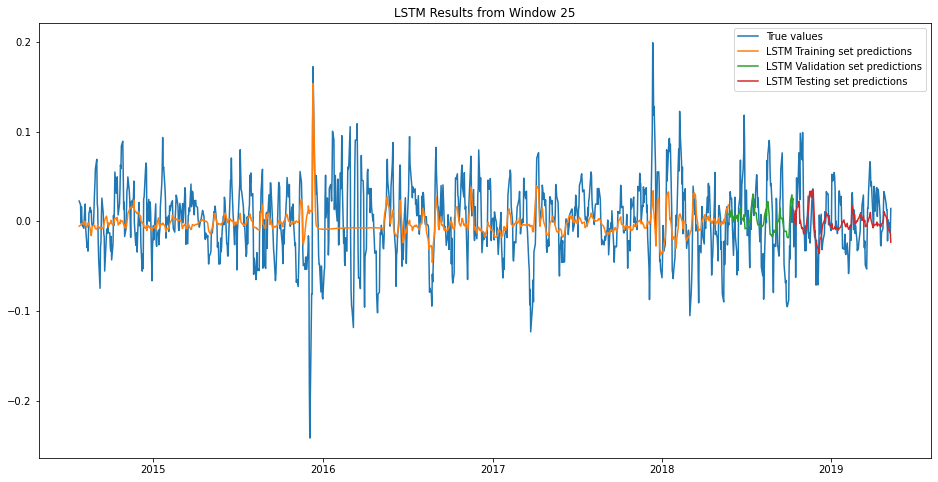

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 5012

Results on Training set: 
MSE = 0.00170057953213524
RMSE = 0.0412380835167596
MAE = 0.031132593928326714
R-Squared = 0.0485728766497977

Results on Validation set: 
MSE = 0.0007346936939458969
RMSE = 0.02710523370026344
MAE = 0.022133958213169574
R-Squared = 0.05369716702950511

Results on Testing set: 
MSE = 0.001326706822445849
RMSE = 0.03642398691035688
MAE = 0.029558831884825665
R-Squared = -0.033904829020889204



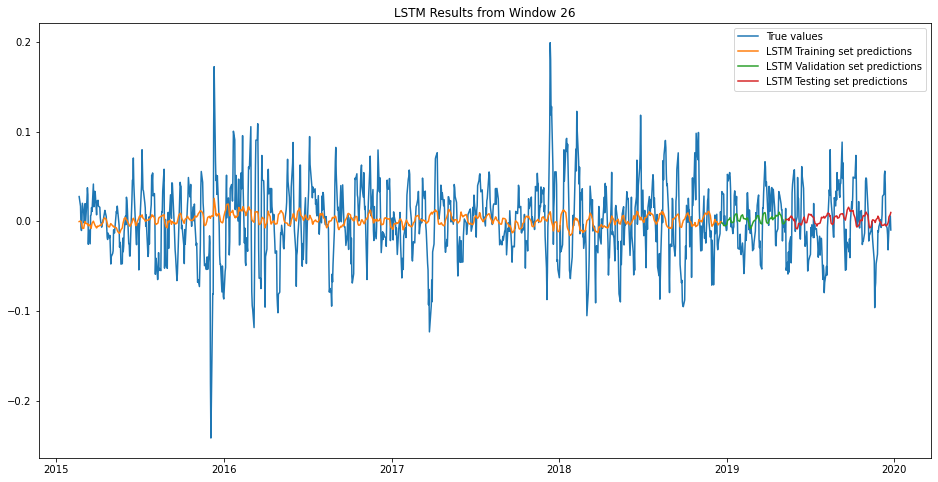

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 106
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.000953473657660206
  dropout = 0.058156104755028686
  units = 256

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 1
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0016291034073205222
RMSE = 0.04036215315515913
MAE = 0.030466103027041357
R-Squared = 0.012433558060580108

Results on Validation set: 
MSE = 0.0007607447826850574
RMSE = 0.027581602250142348
MAE = 0.022027064268366252
R-Squared = -0.22647260315872964

Results on Testing set: 
MSE = 0.0010610783329525646
RMSE = 0.03257419734932182
MAE = 0.02476511459016586
R-Squared = 0.002911406020520646



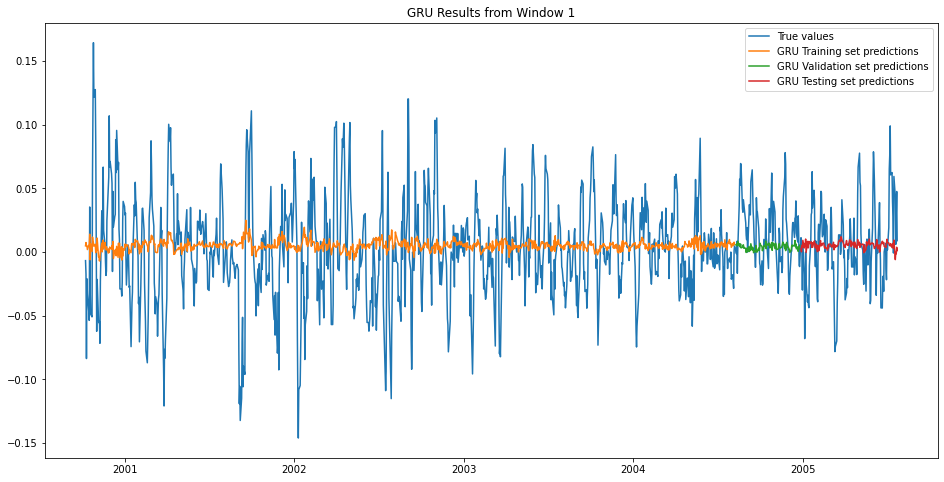

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0013451356353122005
RMSE = 0.03667609078558129
MAE = 0.027622931425807032
R-Squared = 0.01927493582406692

Results on Validation set: 
MSE = 0.0011818975607533193
RMSE = 0.03437873704418647
MAE = 0.025683659231429914
R-Squared = 0.011127807036318549

Results on Testing set: 
MSE = 0.0014895391008646537
RMSE = 0.03859454755356841
MAE = 0.03149792559396079
R-Squared = 0.0230452722190706



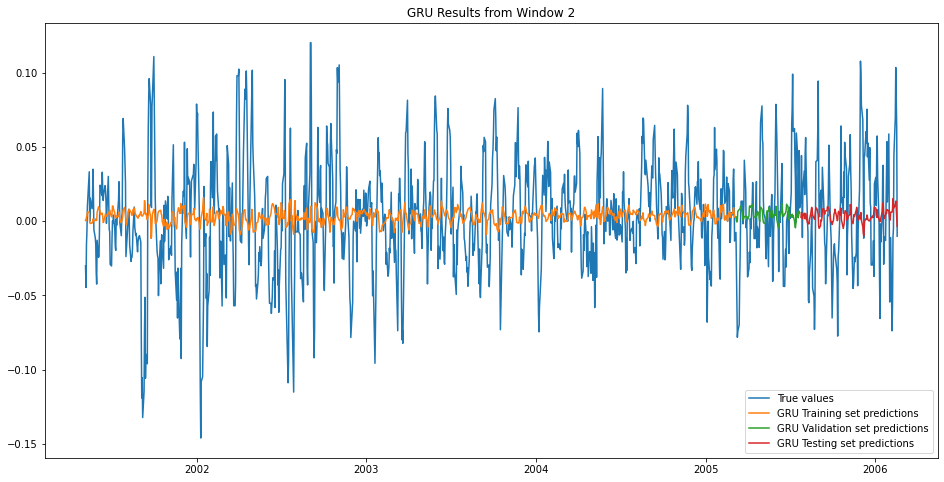

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.00021947492683023807
RMSE = 0.014814686187369547
MAE = 0.011591652832760617
R-Squared = 0.8307986777749392

Results on Validation set: 
MSE = 0.001349176413626832
RMSE = 0.03673113684092601
MAE = 0.029579669024648994
R-Squared = 0.17438879807119056

Results on Testing set: 
MSE = 0.0034184739244297086
RMSE = 0.05846771694216996
MAE = 0.046789239368316325
R-Squared = -0.45167460431286854



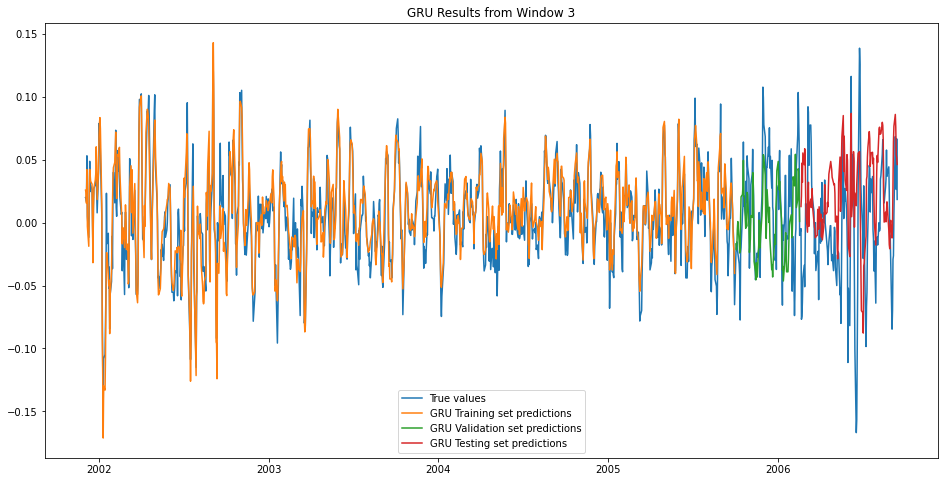

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0014767945798608295
RMSE = 0.03842908507707189
MAE = 0.0296772737924152
R-Squared = -0.22458983246762187

Results on Validation set: 
MSE = 0.002316163185784682
RMSE = 0.04812653307464274
MAE = 0.03622104777053435
R-Squared = 0.17367323975268256

Results on Testing set: 
MSE = 0.00233350927089639
RMSE = 0.048306410246429926
MAE = 0.03781773549343748
R-Squared = -0.5660336014758405



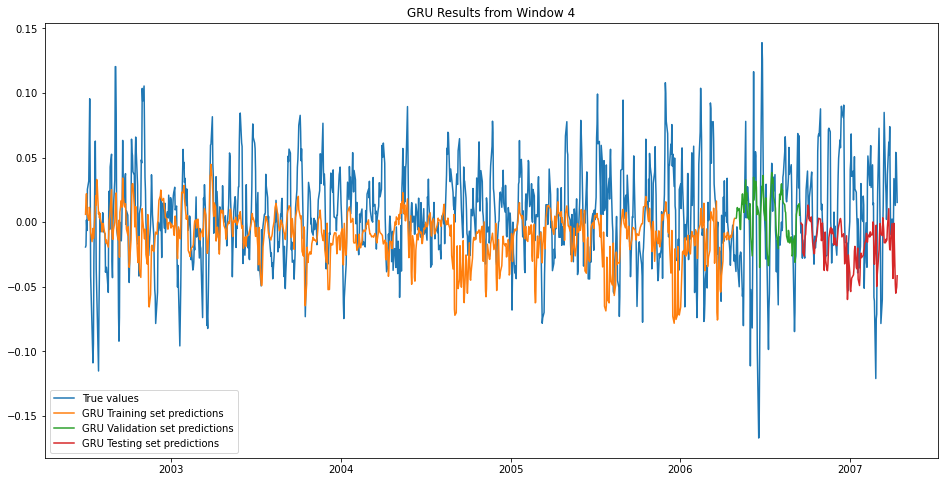

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.001243207553773291
RMSE = 0.03525914851174502
MAE = 0.0277932294575774
R-Squared = 0.0033508773091192046

Results on Validation set: 
MSE = 0.0014610232187465156
RMSE = 0.03822333343321217
MAE = 0.02893932050578075
R-Squared = 0.1351929695512908

Results on Testing set: 
MSE = 0.0015791742943100137
RMSE = 0.03973882603084814
MAE = 0.03193103023161466
R-Squared = -0.11487153817333828



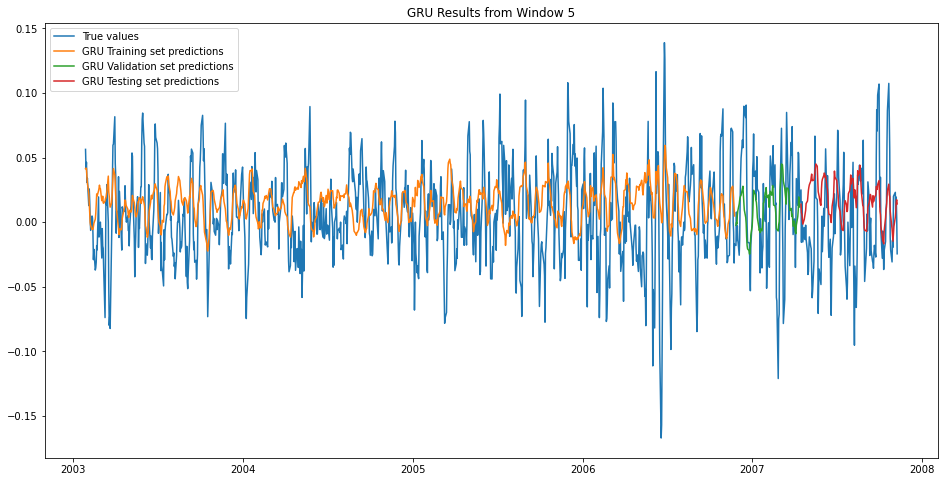

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0006112928334647327
RMSE = 0.024724336866026007
MAE = 0.018522341148535952
R-Squared = 0.5390085356041461

Results on Validation set: 
MSE = 0.0011354132430701448
RMSE = 0.03369589356390693
MAE = 0.026090904459604117
R-Squared = 0.26424608004763295

Results on Testing set: 
MSE = 0.008452170537540727
RMSE = 0.09193568696398982
MAE = 0.0810033579744276
R-Squared = -2.936305630485795



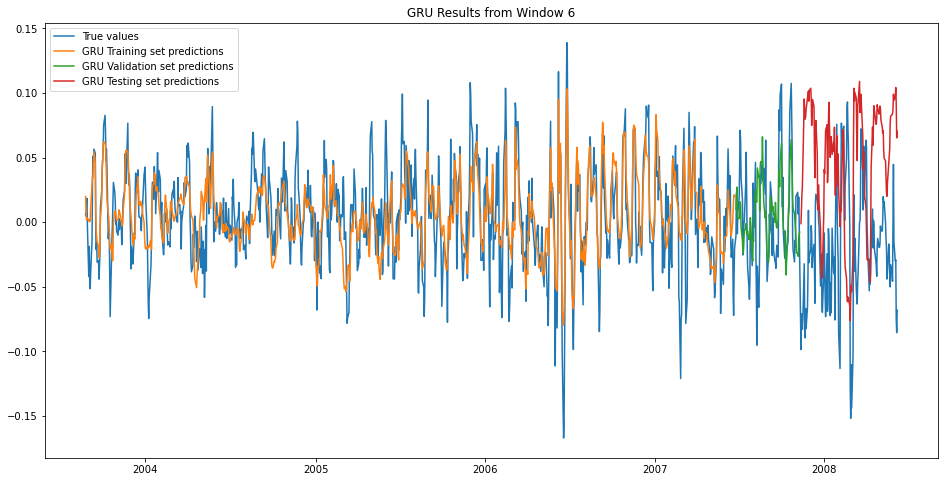

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0014894085679786268
RMSE = 0.03859285643715203
MAE = 0.029932864304330516
R-Squared = -0.004196050129772422

Results on Validation set: 
MSE = 0.002595822398439186
RMSE = 0.050949213913849406
MAE = 0.038926742910759274
R-Squared = -0.04985647817896366

Results on Testing set: 
MSE = 0.005047522959305452
RMSE = 0.07104592148255558
MAE = 0.05403302853140604
R-Squared = -0.03676315510124395



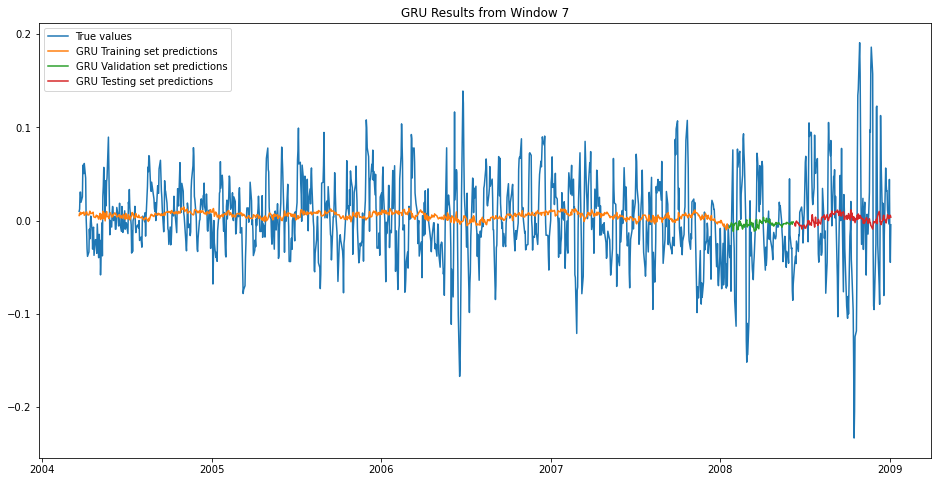

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.00029550559629573604
RMSE = 0.01719027621347999
MAE = 0.01306429441698602
R-Squared = 0.8304732771642541

Results on Validation set: 
MSE = 0.005953348981985134
RMSE = 0.07715794827485457
MAE = 0.05672966069780841
R-Squared = 0.047563556562505216

Results on Testing set: 
MSE = 0.004537437878942429
RMSE = 0.06736050681922182
MAE = 0.05146370455393808
R-Squared = -0.17920868294512804



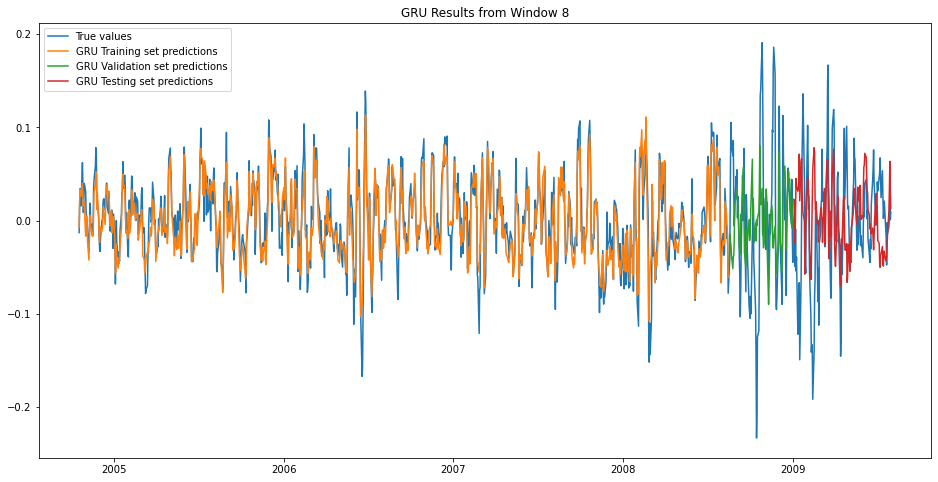

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0023779101564826554
RMSE = 0.04876382015882939
MAE = 0.036947996150180684
R-Squared = 0.06303024311265193

Results on Validation set: 
MSE = 0.0022689394579818245
RMSE = 0.047633385959658846
MAE = 0.035773943745898054
R-Squared = 0.12548856063227998

Results on Testing set: 
MSE = 0.0011083836830229866
RMSE = 0.03329239677498432
MAE = 0.025514254607350354
R-Squared = -0.32755753780661



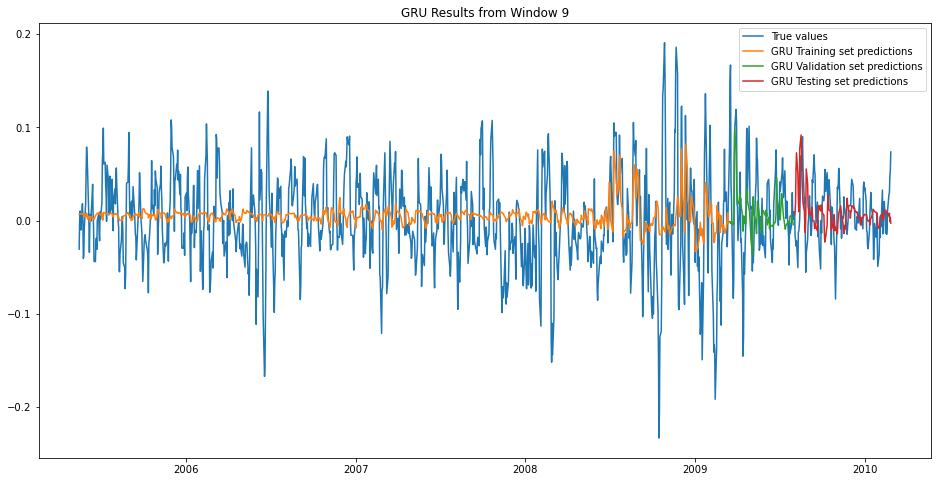

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.002339915046945552
RMSE = 0.04837266838769133
MAE = 0.036307471842979215
R-Squared = 0.12103471035047908

Results on Validation set: 
MSE = 0.0006518454287101873
RMSE = 0.0255312637507466
MAE = 0.02011791274646728
R-Squared = -0.005457344101720274

Results on Testing set: 
MSE = 0.0012928861415152056
RMSE = 0.035956725956560694
MAE = 0.028680909184195608
R-Squared = -0.1654627219628415



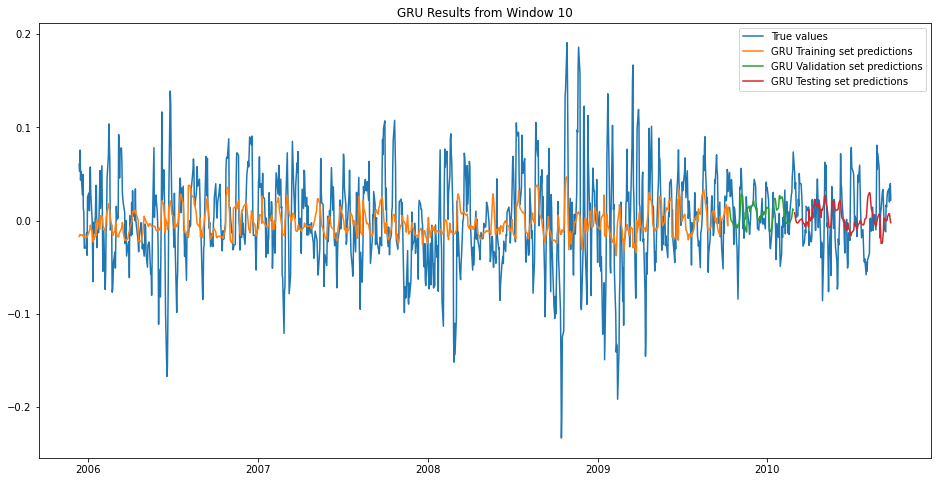

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0023771676014721944
RMSE = 0.0487562057739545
MAE = 0.03651437375371458
R-Squared = 0.013811459900375689

Results on Validation set: 
MSE = 0.0012241064651580405
RMSE = 0.03498723288798416
MAE = 0.02829661658955621
R-Squared = 0.016960834193073038

Results on Testing set: 
MSE = 0.0010485625307089955
RMSE = 0.03238151526270807
MAE = 0.026320826452188917
R-Squared = 0.02749949618941283



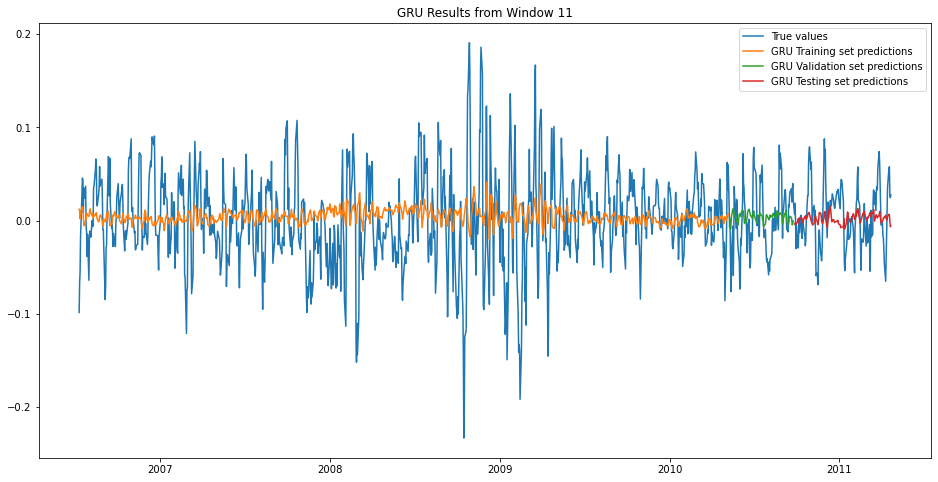

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001661063256245895
RMSE = 0.04075614378527359
MAE = 0.029948467525551897
R-Squared = 0.3038483638598348

Results on Validation set: 
MSE = 0.0009155666729593406
RMSE = 0.030258332289789875
MAE = 0.024730498285119692
R-Squared = -0.040238042247902506

Results on Testing set: 
MSE = 0.0008921446663372416
RMSE = 0.029868790841566413
MAE = 0.023936186475630145
R-Squared = -0.08786554160412896



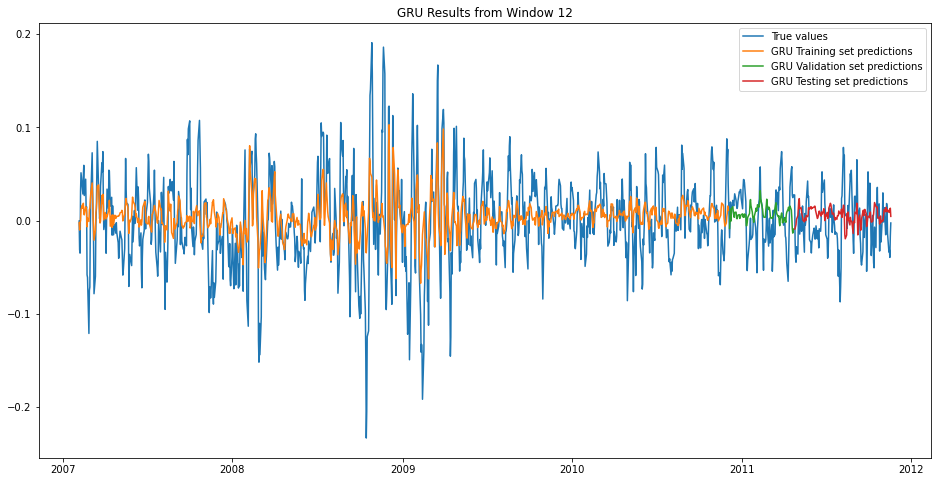

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.002055516918678736
RMSE = 0.04533780893116402
MAE = 0.033073747378077376
R-Squared = 0.09752101974489935

Results on Validation set: 
MSE = 0.0008172641208213103
RMSE = 0.028587831691496125
MAE = 0.02221657639079458
R-Squared = 0.14418354750640672

Results on Testing set: 
MSE = 0.0007202598582894852
RMSE = 0.026837657466505627
MAE = 0.021463743807747473
R-Squared = -0.21739291477138978



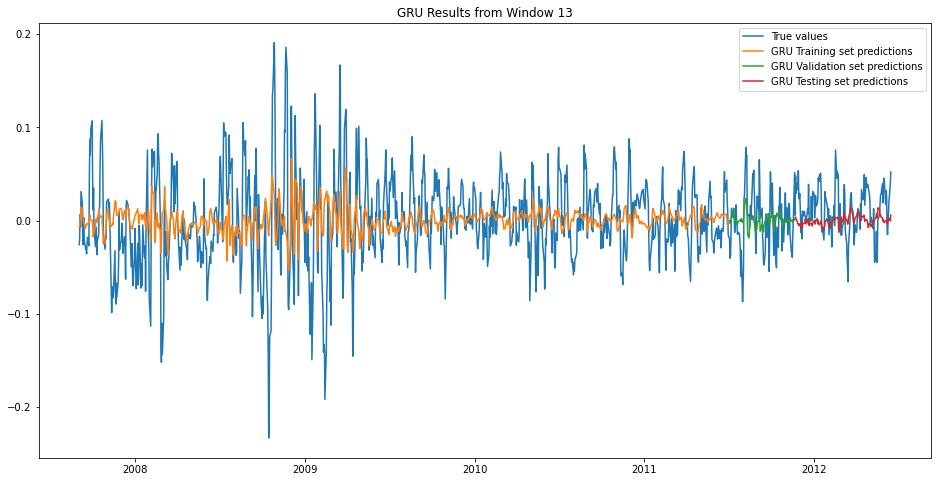

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0017082914210196963
RMSE = 0.04133148220206597
MAE = 0.029630208710235473
R-Squared = 0.14030675899198586

Results on Validation set: 
MSE = 0.0006573873455870166
RMSE = 0.0256395660179149
MAE = 0.02057236152188384
R-Squared = 0.03318106369594698

Results on Testing set: 
MSE = 0.0007786105888926608
RMSE = 0.027903594551467036
MAE = 0.02237462387995242
R-Squared = 0.12265580389778541



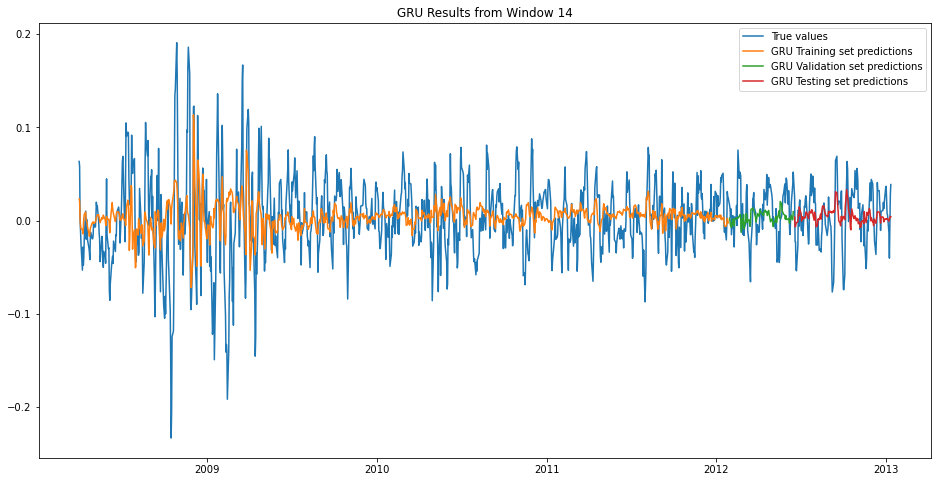

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.001524593238344033
RMSE = 0.03904603998287193
MAE = 0.027704812746591475
R-Squared = 0.029542287959655522

Results on Validation set: 
MSE = 0.0009315235439827031
RMSE = 0.03052087062950045
MAE = 0.02369773333134064
R-Squared = 0.09148003988793163

Results on Testing set: 
MSE = 0.001605662732545697
RMSE = 0.040070721637446176
MAE = 0.029378724962452127
R-Squared = -0.6383998850491448



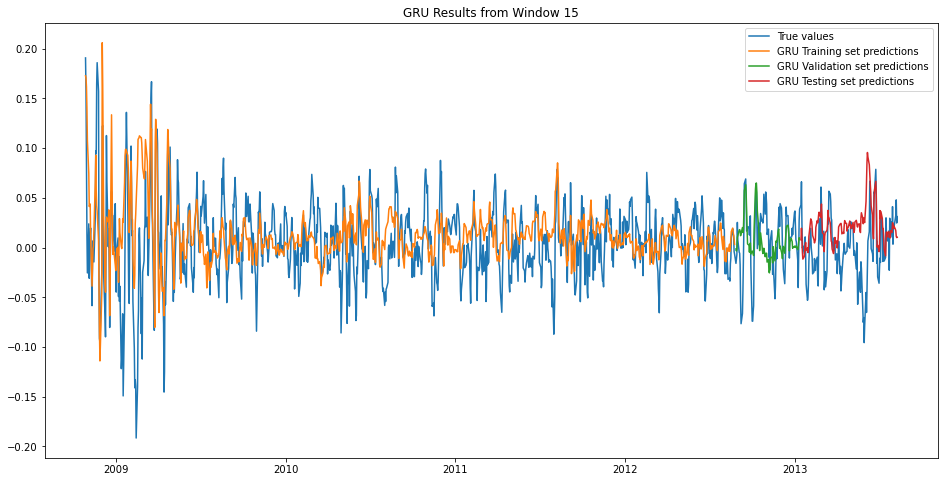

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.000850906113597237
RMSE = 0.02917029505502536
MAE = 0.02335843707534759
R-Squared = 0.062026447827692066

Results on Validation set: 
MSE = 0.0011111651140662461
RMSE = 0.03333414336781802
MAE = 0.024896642737495037
R-Squared = -0.09796133044609912

Results on Testing set: 
MSE = 0.0011284098386618515
RMSE = 0.03359181207767529
MAE = 0.026858565793044242
R-Squared = -0.02534529442836586



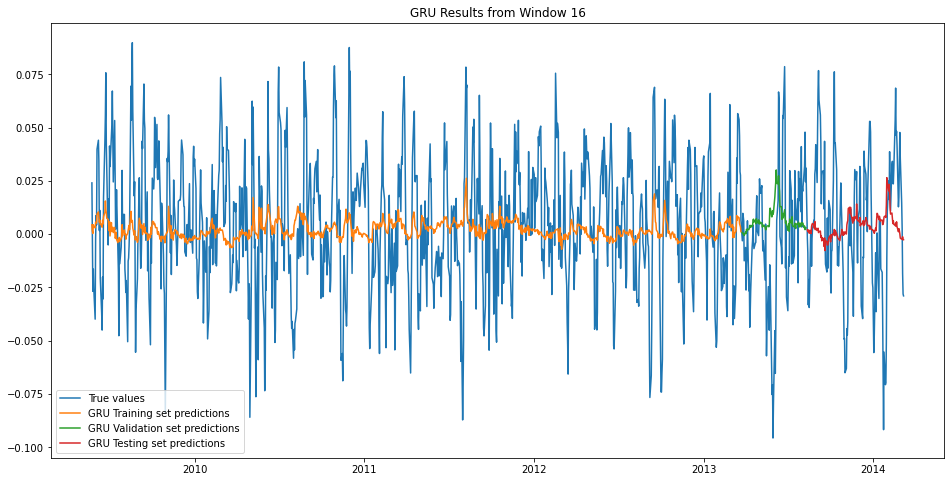

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0009871029902803377
RMSE = 0.031418195210424445
MAE = 0.024927992253923306
R-Squared = -0.07548808870764412

Results on Validation set: 
MSE = 0.0010619254522962712
RMSE = 0.032587197674796634
MAE = 0.026758592481426136
R-Squared = 0.08592178501479042

Results on Testing set: 
MSE = 0.0007324160577226651
RMSE = 0.027063186392637974
MAE = 0.021560730281400597
R-Squared = -0.43270026040444076



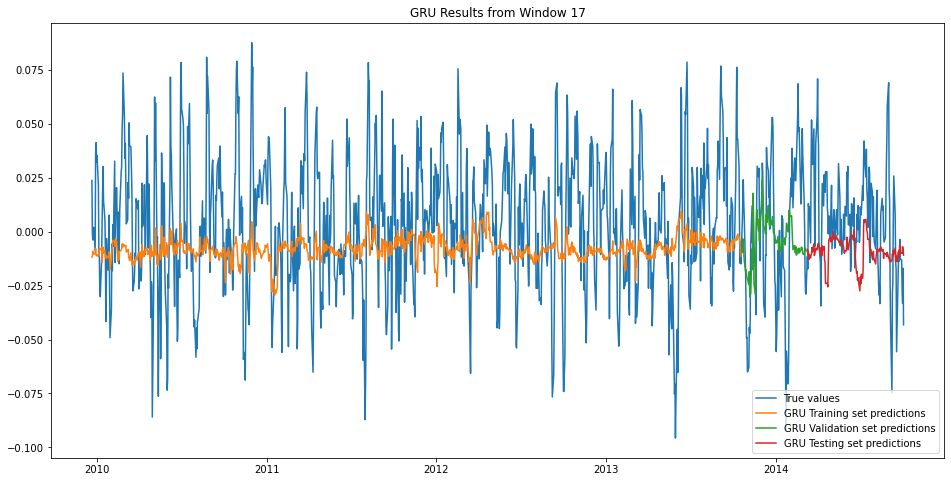

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0009144342282989837
RMSE = 0.0302396135606754
MAE = 0.02381005708788367
R-Squared = 0.002294822434296351

Results on Validation set: 
MSE = 0.0005097388841906407
RMSE = 0.0225773976399106
MAE = 0.016505651774574394
R-Squared = -0.0007849462284912345

Results on Testing set: 
MSE = 0.0007510307544653281
RMSE = 0.027404940329534163
MAE = 0.021163838610862833
R-Squared = 0.02073419620231509



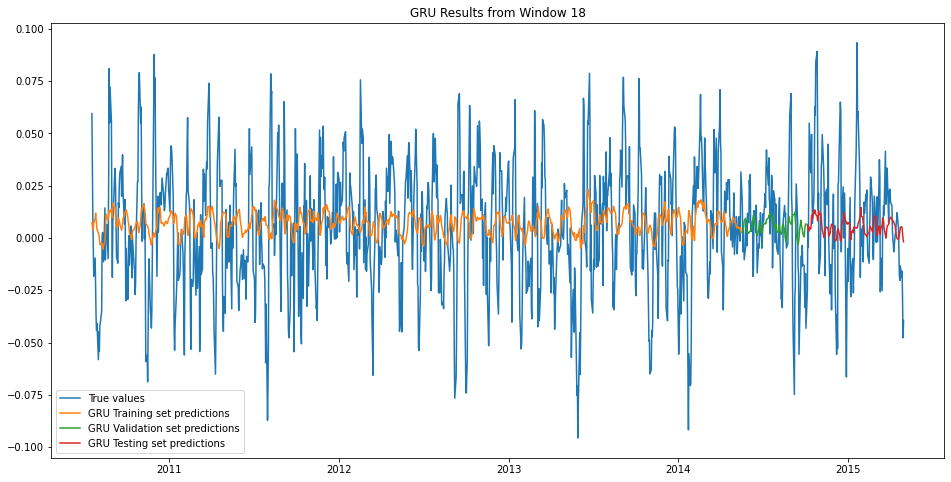

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0008332401304277373
RMSE = 0.028865899092661868
MAE = 0.022572522566545433
R-Squared = 0.03254893425576777

Results on Validation set: 
MSE = 0.0006064839832476492
RMSE = 0.024626895525982344
MAE = 0.01865194765836821
R-Squared = 0.046801932167921945

Results on Testing set: 
MSE = 0.0012422167693590996
RMSE = 0.03524509567810959
MAE = 0.028916041143994237
R-Squared = -0.07703353057444717



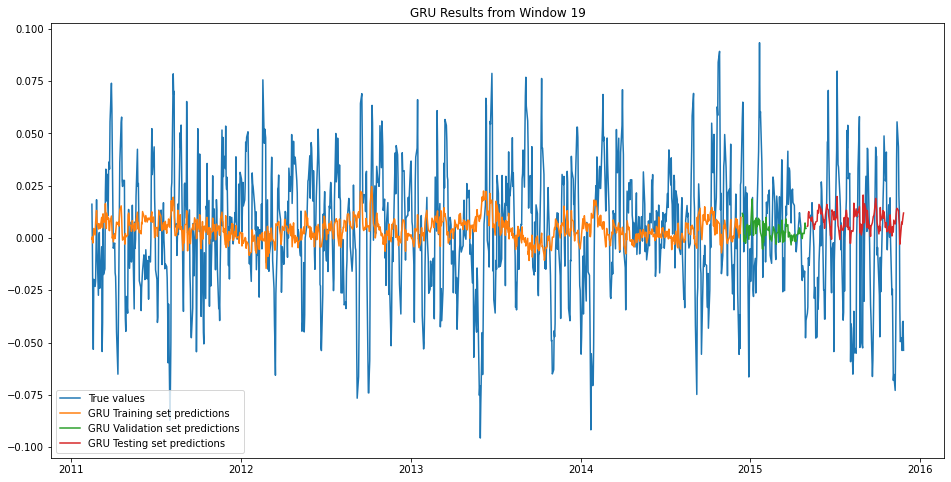

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0007220858806404806
RMSE = 0.02687165571081322
MAE = 0.02084479672784121
R-Squared = 0.12973625129748378

Results on Validation set: 
MSE = 0.0014424405414326694
RMSE = 0.0379794752653676
MAE = 0.030855489639854117
R-Squared = -0.17200517156197748

Results on Testing set: 
MSE = 0.003980387924691322
RMSE = 0.06309031561730628
MAE = 0.04686009299981802
R-Squared = -0.13198787200474227



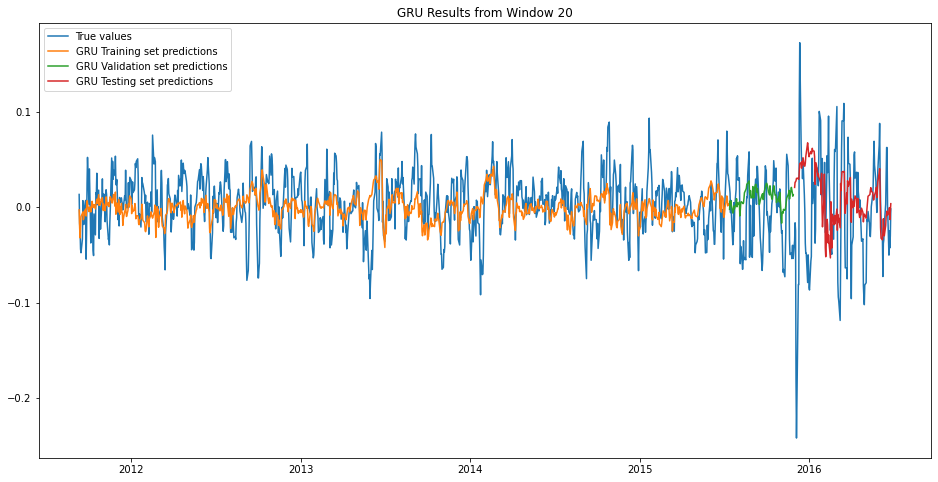

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0010468198957336932
RMSE = 0.03235459620724223
MAE = 0.024258529711692112
R-Squared = 0.07084628104180402

Results on Validation set: 
MSE = 0.002417612905366742
RMSE = 0.04916922721953989
MAE = 0.040661789312273024
R-Squared = 0.11244194554679621

Results on Testing set: 
MSE = 0.0012681257028245648
RMSE = 0.03561075262929112
MAE = 0.02830508583796823
R-Squared = -0.019898304403979328



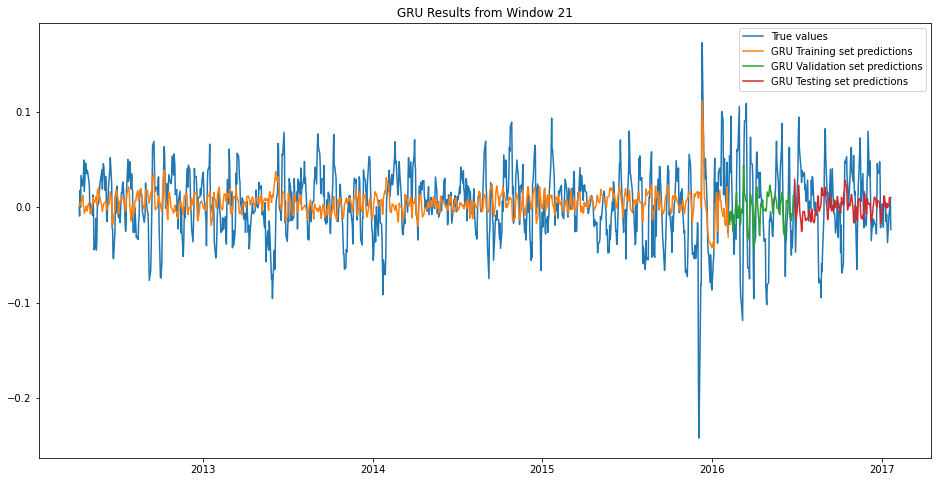

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.001272418158304567
RMSE = 0.035670970806869935
MAE = 0.02683093851311256
R-Squared = 0.05846291058865927

Results on Validation set: 
MSE = 0.0007980233688857137
RMSE = 0.028249307405416396
MAE = 0.02209263878885848
R-Squared = 0.1461158334407856

Results on Testing set: 
MSE = 0.0013991062252050111
RMSE = 0.03740462839282074
MAE = 0.028161031431026197
R-Squared = -0.11752959664543883



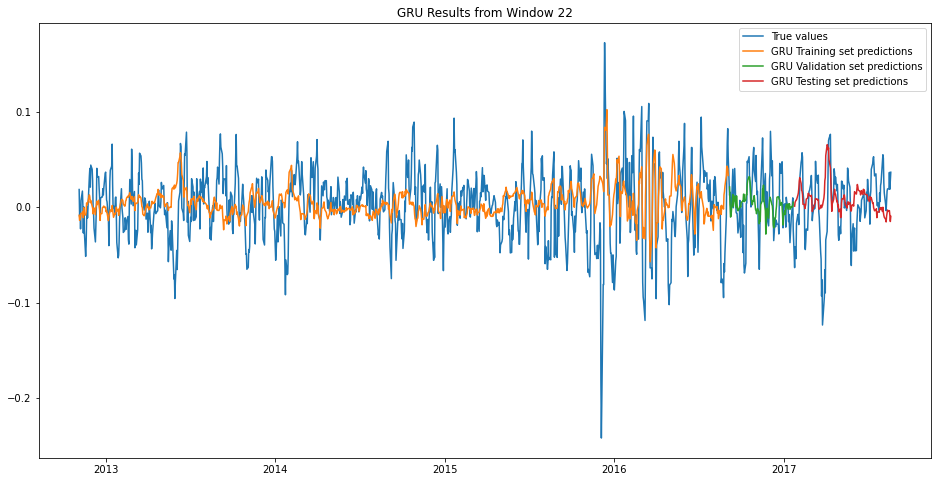

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0015779123981825424
RMSE = 0.039722945487243796
MAE = 0.029921110034122036
R-Squared = -0.10563471433482197

Results on Validation set: 
MSE = 0.0007060726509780873
RMSE = 0.026572027603818403
MAE = 0.01989923648152857
R-Squared = -0.004079296909705654

Results on Testing set: 
MSE = 0.0022341385461857764
RMSE = 0.04726667479510037
MAE = 0.03601979601753858
R-Squared = -0.005042682182326175



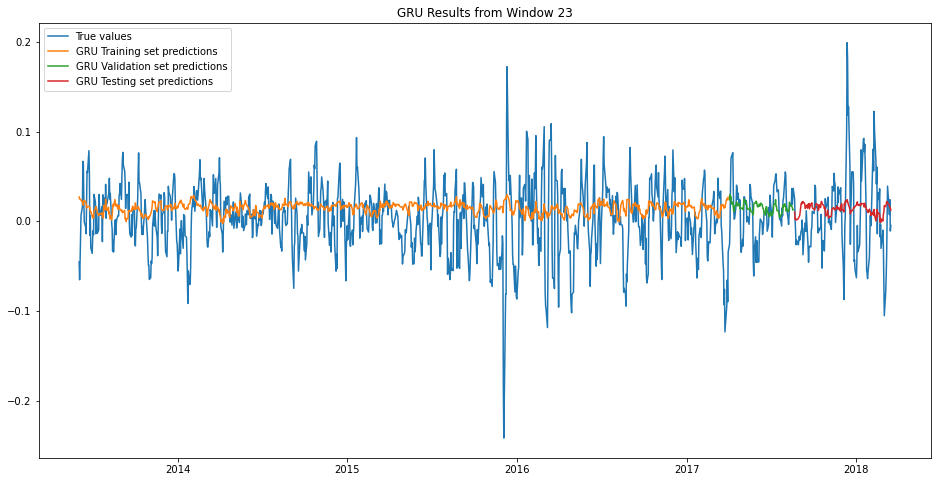

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0011101964545615543
RMSE = 0.0333196106604137
MAE = 0.02442508112501104
R-Squared = 0.19931066655034724

Results on Validation set: 
MSE = 0.0029573544029706674
RMSE = 0.05438156307950947
MAE = 0.04216479078583612
R-Squared = 0.0002801570236748985

Results on Testing set: 
MSE = 0.002134221389287856
RMSE = 0.04619763402261912
MAE = 0.03740170137366678
R-Squared = -0.23379221521783977



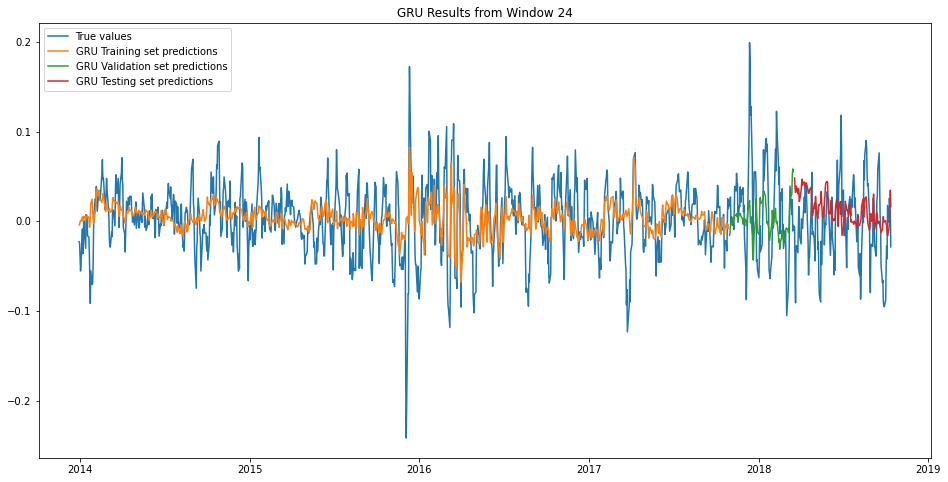

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0012315712007859934
RMSE = 0.03509374874227593
MAE = 0.02648180399838522
R-Squared = 0.25368843268728647

Results on Validation set: 
MSE = 0.001718674512212129
RMSE = 0.041456899452469054
MAE = 0.03342338184222766
R-Squared = 0.14734160913037186

Results on Testing set: 
MSE = 0.001120691822137266
RMSE = 0.03347673553585036
MAE = 0.026525748987565868
R-Squared = -0.055397002791679695



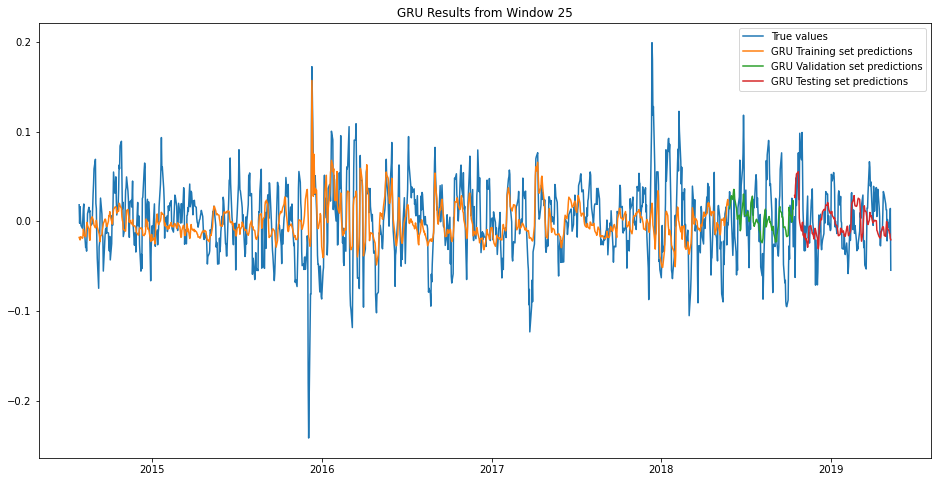

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 5011

Results on Training set: 
MSE = 0.0014665046708020907
RMSE = 0.03829496926232075
MAE = 0.02859144184101113
R-Squared = 0.17968048735638031

Results on Validation set: 
MSE = 0.0007248007964286825
RMSE = 0.02692212466408776
MAE = 0.021811818036911176
R-Squared = 0.09525593502417495

Results on Testing set: 
MSE = 0.0011526075325122755
RMSE = 0.03395007411644746
MAE = 0.02738668066085508
R-Squared = 0.09536213057158194



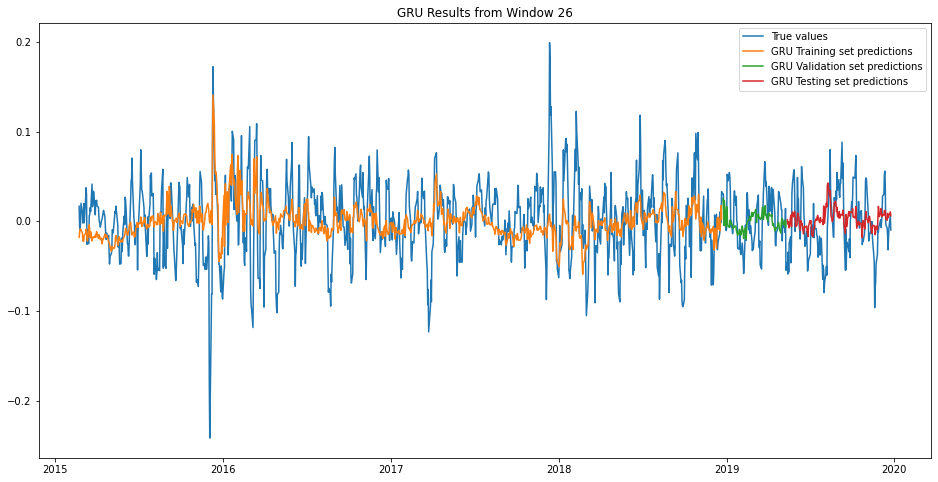

In [10]:
#Declaring model parameters
sequencelength = 107
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0018153052293763605
RMSE = 0.04260639892523611
MAE = 0.032045472856514996
R-Squared = -0.1259670058314586

GRU model results on the Testing set
MSE = 0.002016908652845407
RMSE = 0.044910006155036396
MAE = 0.03329450357735402
R-Squared = -0.25073094130175644

Naive model results on the Testing set
MSE = 0.003655968878998686
RMSE = 0.06046460848296866
MAE = 0.04518888601186491
R-Squared = -1.270190182421754

Drift model results on the Testing set
MSE = 0.004425219470370527
RMSE = 0.06652232309811892
MAE = 0.04924226573844987
R-Squared = -1.7478597682834311



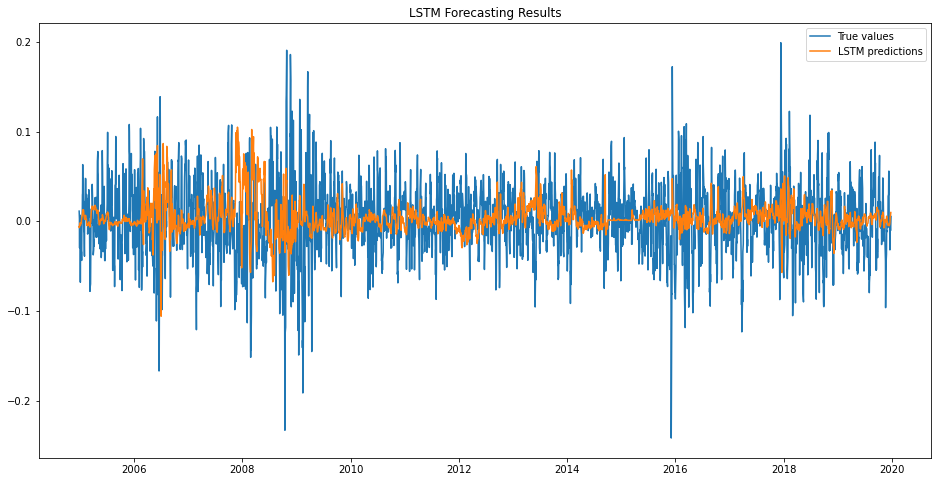

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

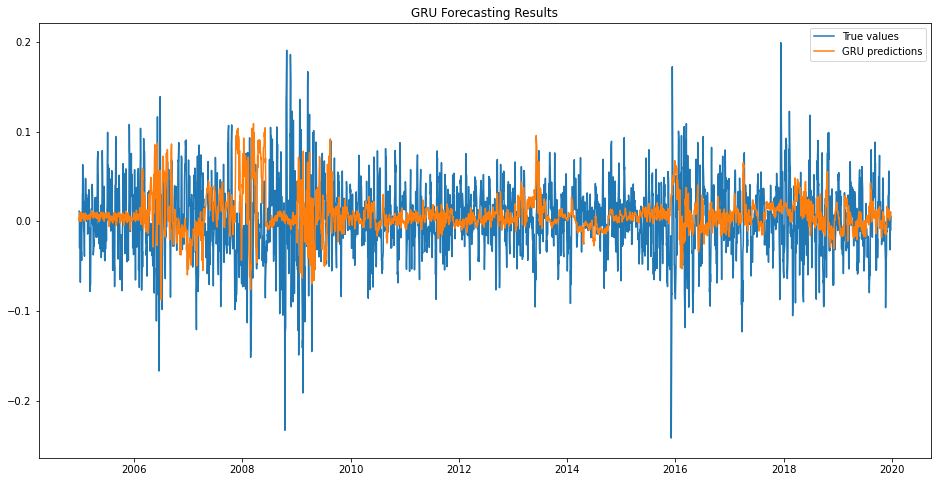

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

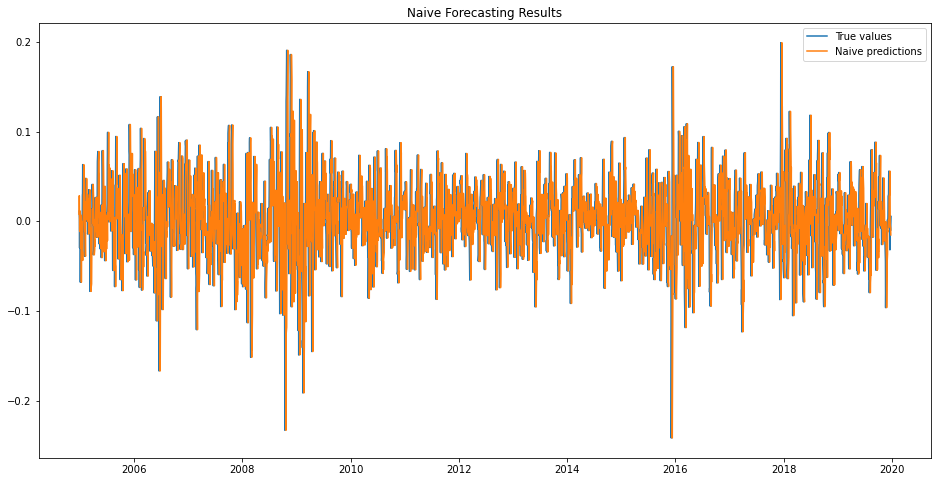

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

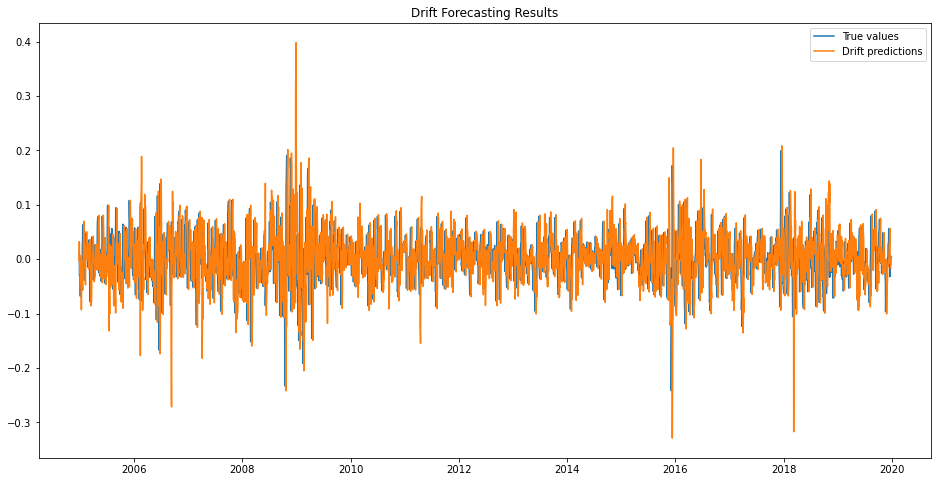

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['FSR LSTM'] = lstm_predictions[-numpreds:]
savePredictions['FSR GRU'] = gru_predictions[-numpreds:]
savePredictions['FSR Naive'] = naive_predictions[-numpreds:]
savePredictions['FSR Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./FSR_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

FSR LSTM   FSR GRU  FSR Naive  FSR Drift
Date                                                
2004-12-27 -0.006110  0.003035   0.007871  -0.002603
2004-12-28 -0.007212  0.000203   0.028438   0.032128
2004-12-29 -0.006523  0.005076   0.014637   0.010249
2004-12-30 -0.003869  0.004212  -0.010327  -0.026757
2004-12-31 -0.002038  0.009221  -0.011389  -0.026808